### Data -- Wait time stats actual view

In [196]:
# pip install psycopg2
#!pip install snowflake
#!pip install lightgbm
#!pip install gtfs-realtime-bindings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import psycopg2
from datetime import datetime
import requests
from datetime import date
from datetime import timedelta
import snowflake.connector

In [197]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user='SPARK',
    authenticator = "externalbrowser",
    account='BROOKLYNSPORTSANDENTERTAINMENT-BSEGLOBAL',  # e.g., xy12345.us-east-1
    warehouse='All Too Ware',
    database='BSEDW',
    schema='WAITTIME', 
    role = "SNOWFLAKE_DOMINATEAI"
)
cursor = conn.cursor()
# Explicitly activate the warehouse
cursor.execute('USE WAREHOUSE "All Too Ware"')

# Query data
query = "SELECT * FROM WAITTIME_STATSACTUALVIEW where EVENT_DATE <= '2025-07-27'"
cursor.execute(query)

# Convert to pandas DataFrame
df = cursor.fetch_pandas_all()

# Close the connection
cursor.close()
conn.close()

# Display results
print(df.head())


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://bseglobal.okta.com/app/snowflake/exkqh96ogn06lUM3g4x7/sso/saml?SAMLRequest=rZNJc%2BMgEIX%2Fioo5SyBviSnbKU88nrgqXuIlh9yQhGVKCBQaWXZ%2B%2FSBvlTkkp9woeM33uh%2F0Hg659PbcgNCqj8KAII%2BrWCdCpX20WY%2F9e%2BSBZSphUiveR0cO6GHQA5bLgg5Lu1NL%2Fl5ysJ67SAGtD%2FqoNIpqBgKoYjkHamO6Gk6faSMglAFwYx0OXUoSEI61s7agGFdVFVTNQJsUNwghmHSxU9WSX%2BgTovieURhtdazlteTgevoCEWLSqhFO4QiLS%2BFvoc4j%2BI4SnUVAn9brhb%2BYr9bIG167e9QKypybFTd7EfPN8vlsAJyDyGidyaOCQhsLbrhcWVfFhMrdyo%2BAp1JHTAagdLWVLOOxzovSOljgVnjLEyx1KtwIJ6M%2BKjKR2KncPW2W46Jtlx9Zh83Y20v592Uy3zfnEWd%2FSDErP6IF2B3EyHu9Bt6oA58AlHyi6pit2yKNtk%2FufXK3Dru00aTtMGi1yRvyRi5moZg9Vd56uZnVmWUne6wo8M055ofsfdft6FSRjtxMm2nrcIcBNK5zROenRE8WzOCHBtTDny%2B9PNaZy28yWmgp4qM31iZn9ut4wyA87YjE356klOdMyGGSGA7gYpZSV4%2BGM%2Bv%2BhDUlR3hw

In [198]:
# Convert all column names to lowercase
df.columns = df.columns.str.lower()

In [199]:
needed_columns = ['event_name',
'event_name_long',
'event_date',
'event_time',
'event_day',
'starttime',
'team',
'minor_category',
'property',
'numberinline',
'relative start (minutes)',
'wait time (minutes)',
'time category']

df = df[needed_columns]

In [200]:
# CSV
df.to_csv('wait time_v4.csv', index=False)  

In [201]:
# Convert times 
df['event_date'] = pd.to_datetime(df['event_date'])
df['starttime'] = pd.to_datetime(df['starttime'], errors='coerce')
df['event_time'] = pd.to_datetime(df['event_time'], format='%H:%M:%S').dt.time

# Note: relative start (minutes) should already be calculated in the source data
# If it's missing, we would need the actual timestamp column to compute it

In [202]:
# Remove upsell or irrelevant events
df = df[~(df['event_name_long'].str.contains("Upsell", na=False) | 
          df['event_name_long'].str.contains("CANCELED", na=False) |
          df['event_name_long'].str.contains("Cancelled", na=False) |
          df['event_name_long'].str.contains("Libs for Kids 2023 Holding Event", na=False) |
          df['event_name_long'].str.contains("Test", na=False) |
          df['team'].str.contains("Test", case=False, na=False))]

# Drop nulls in critical columns
df = df.dropna(subset=['relative start (minutes)', 'wait time (minutes)', 'numberinline'])

In [203]:
# Verify that test - brooklyn nets rows are removed
test_rows = df[df['team'].str.contains("test", case=False, na=False)]
print(f"Rows with 'test' in team name after filtering: {len(test_rows)}")
if len(test_rows) > 0:
    print("Teams still containing 'test':")
    print(test_rows['team'].value_counts())
else:
    print("✓ Successfully removed all rows with 'test' in team name")

Rows with 'test' in team name after filtering: 0
✓ Successfully removed all rows with 'test' in team name


### Relative start time cutoffs

In [204]:
# Print minimum and maximum event_date
print('Minimum event_date:', df['event_date'].min())
print('Maximum event_date:', df['event_date'].max())

Minimum event_date: 2023-09-01 00:00:00
Maximum event_date: 2025-07-26 00:00:00


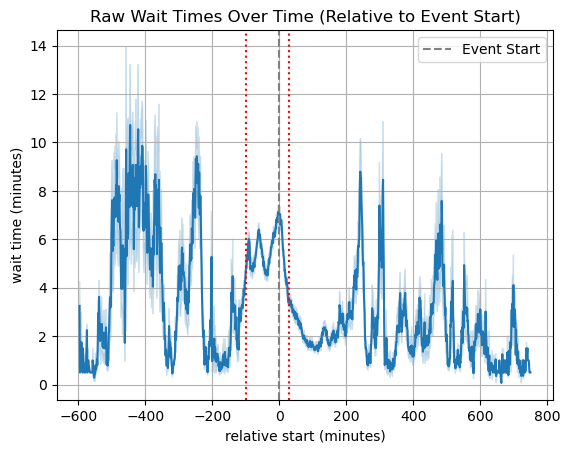

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=df, x='relative start (minutes)', y='wait time (minutes)')
plt.title("Raw Wait Times Over Time (Relative to Event Start)")
plt.axvline(0, linestyle='--', color='gray', label='Event Start')
plt.axvline(-100, linestyle=':', color='red')
plt.axvline(30, linestyle=':', color='red')
plt.legend()
plt.grid(True)
plt.show()


In [206]:
# Round to nearest minute
df['relative start (minutes)'].astype(int) 

# Filter out after-event tail if not useful
df = df[df['relative start (minutes)'] <= 30] # Operataional cutoff 
df = df[df['relative start (minutes)'] >= -100]

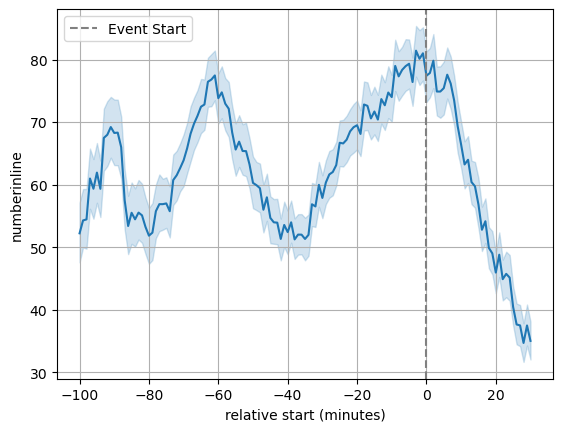

In [207]:
sns.lineplot(data=df, x='relative start (minutes)', y='numberinline')
plt.axvline(0, linestyle='--', color='gray', label='Event Start')
plt.legend()
plt.grid(True)
plt.show()

In [208]:
# 5 minute buckets 
df['5_minute_bucket'] = (df['relative start (minutes)'] // 5) * 5

### Queue trend with numberline

In [209]:
# Adding queue trend features (when lines are accelearating or decelerating)
df = df.sort_values(['event_name','relative start (minutes)'])

# 3-minute rolling mean -- congestion at specific times 
df['queue_mean_3'] = (
    df.groupby('event_name')['numberinline']
      .transform(lambda s: s.rolling(window=3, min_periods=1).mean())
)

df['day_of_week'] = df['event_date'].dt.dayofweek

# 3-minute rolling slope (simple linear trend) -- accelration or deceleration of queue
def _slope(a):
    idx = np.arange(len(a))
    return np.polyfit(idx, a, 1)[0]  # coefficient of x

df['queue_slope_3'] = (
    df.groupby('event_name')['numberinline']
      .transform(lambda s: s.rolling(window=3, min_periods=2).apply(_slope, raw=True))
      .fillna(0)
)


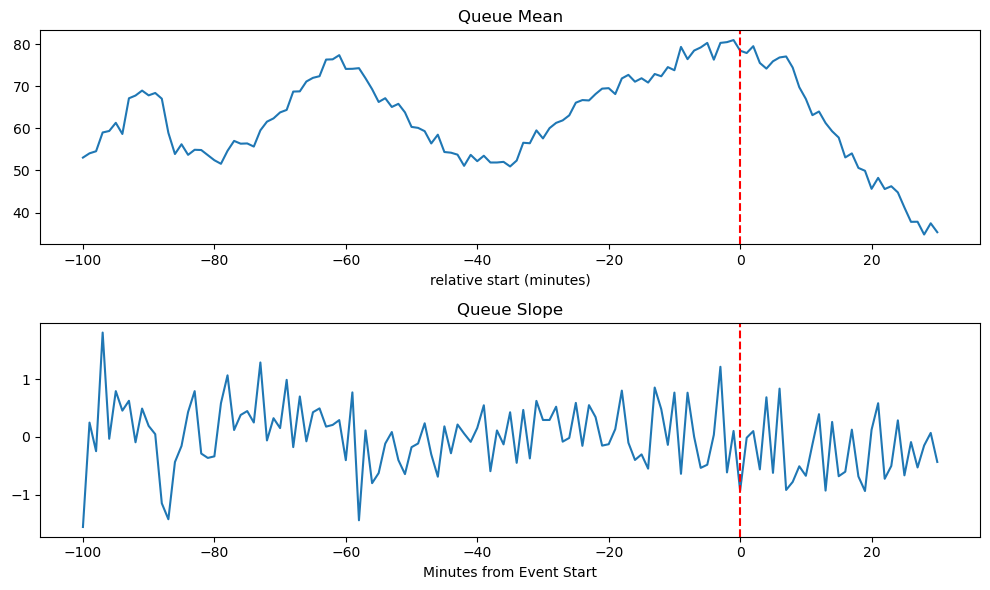

In [210]:
# Combined plot
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
df.groupby('relative start (minutes)')['queue_mean_3'].mean().plot()
plt.title('Queue Mean')
plt.axvline(0, color='red', linestyle='--')

plt.subplot(2,1,2)
df.groupby('relative start (minutes)')['queue_slope_3'].mean().plot()
plt.title('Queue Slope')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Minutes from Event Start')

plt.tight_layout()
plt.show()

### Cyclical

In [211]:
# Add cyclical time features for better modeling
df['hour'] = pd.to_datetime(df['event_time'], format='%H:%M:%S').dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Day of week cyclical encoding
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Minute bucket cyclical encoding (for within-event timing)
df['minute_sin'] = np.sin(2 * np.pi * df['relative start (minutes)'] / 30)  # 30 minute cycle
df['minute_cos'] = np.cos(2 * np.pi * df['relative start (minutes)'] / 30)

In [212]:
df['is_weekend'] = np.where(df['event_day'].isin(['SAT', 'SUN']), 1, 0)

### Attendance 

In [213]:
# Attendence counts 
def run_query():
#Connect with the database
    DW_HOST = "172.22.12.130"
    DW_PORT = "5432"
    DW_USER = "spark"
    DW_PASS = "Brooklyn_2025!"
    DW_BSEDW_DATABASE = "bsedw"
    #Use psycopg2 for interacting with PostgreSQL from the Python scripting language.
    connection = psycopg2.connect(
            user = DW_USER,
            password = DW_PASS,
            host = DW_HOST,
            port = DW_PORT,
            database = DW_BSEDW_DATABASE
    )
#Edit your query below (between the ''' and '''):

    query = '''
 SELECT event_date, event_time, count (*)
        FROM archtics_new.v_attendance_scans vas
        WHERE 
            result_code_desc = 'Initial Entry'
        group by 1, 2
    '''
    test = pd.read_sql(query, con = connection)

    return(test)

run_query()
attendance = run_query()
print(attendance)

    event_date event_time  count
0   2023-03-13   20:00:00      5
1   2023-03-17   17:30:00   3131
2   2023-04-01   20:00:00  10986
3   2023-05-05   19:00:00   5158
4   2023-05-06   11:00:00    309
..         ...        ...    ...
469 2025-07-26   19:00:00  14200
470 2025-07-29   19:30:00  15537
471 2025-07-31   20:00:00   9553
472 2025-08-04   19:30:00  11945
473 2025-08-05   19:00:00  16411

[474 rows x 3 columns]


In [214]:
# Fix attendance data formatting for successful merge
attendance['event_date'] = pd.to_datetime(attendance['event_date'])
# Convert attendance event_time from string to time object (key fix!)
if isinstance(attendance['event_time'].iloc[0], str):
    attendance['event_time'] = pd.to_datetime(attendance['event_time']).dt.time
elif isinstance(attendance['event_time'].iloc[0], pd.Timestamp):
    attendance['event_time'] = attendance['event_time'].dt.time

# Save to CSV
attendance.to_csv('attendance_v4.csv', index=False) 

In [215]:

# Now perform the merges properly with fixed formatting
print("\n=== Merging with attendance data ===")
df_merged = pd.merge(df, attendance, on=['event_date', 'event_time'], how='left', suffixes=('', '_attendance'))
attendance_matches = df_merged['count'].notna().sum()
print(f"After attendance merge shape: {df_merged.shape}")
print(f"Attendance matches: {attendance_matches} out of {len(df_merged)} records ({attendance_matches/len(df_merged)*100:.1f}%)")
print("After attendance merge columns:", df_merged.columns.tolist())

# Update the main df variable
df = df_merged.copy()

print("\n=== Final df summary ===")
print("Final df shape:", df.shape)
print("Final df columns:", df.columns.tolist())
print(f"Records with both attendance and category data: {((df['count'].notna()) & (df['minor_category'].notna())).sum()}")
print("\nSample of final df:")
print(df[['event_date', 'event_time', 'event_day', 'count']].head())


=== Merging with attendance data ===
After attendance merge shape: (209802, 26)
Attendance matches: 209802 out of 209802 records (100.0%)
After attendance merge columns: ['event_name', 'event_name_long', 'event_date', 'event_time', 'event_day', 'starttime', 'team', 'minor_category', 'property', 'numberinline', 'relative start (minutes)', 'wait time (minutes)', 'time category', '5_minute_bucket', 'queue_mean_3', 'day_of_week', 'queue_slope_3', 'hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos', 'is_weekend', 'count']

=== Final df summary ===
Final df shape: (209802, 26)
Final df columns: ['event_name', 'event_name_long', 'event_date', 'event_time', 'event_day', 'starttime', 'team', 'minor_category', 'property', 'numberinline', 'relative start (minutes)', 'wait time (minutes)', 'time category', '5_minute_bucket', 'queue_mean_3', 'day_of_week', 'queue_slope_3', 'hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos', 'is_weekend', '

In [216]:
# Check rows with NaN count values
nan_count_rows = df[df['count'].isna()]

print(f"Number of rows with NaN count: {len(nan_count_rows)}")
print(f"Percentage of rows with NaN count: {len(nan_count_rows)/len(df)*100:.1f}%")

Number of rows with NaN count: 0
Percentage of rows with NaN count: 0.0%


In [217]:
nan_count_rows['event_name_long'].drop_duplicates()

Series([], Name: event_name_long, dtype: object)

### Tiers

In [218]:
def run_query():
#Connect with the database
    DW_HOST = "172.22.12.130"
    DW_PORT = "5432"
    DW_USER = "spark"
    DW_PASS = "Brooklyn_2025!"
    DW_BSEDW_DATABASE = "bsedw"
    #Use psycopg2 for interacting with PostgreSQL from the Python scripting language.
    connection = psycopg2.connect(
            user = DW_USER,
            password = DW_PASS,
            host = DW_HOST,
            port = DW_PORT,
            database = DW_BSEDW_DATABASE
    )
#Edit your query below (between the ''' and '''):

    query = '''
select event_date, tier::text
from bi.liberty_season_23 ls 

union all 

select "Date"::date as event_date, "Individual Tier"::text  as tier
from bi.liberty_season_24 ls 

union all 

select event_date, "start_of_season_individual_tier" as tier
from bi.liberty_season_25 ls

union all

select event_date, tier::text
from bi.nets_season_22 ns

union all

select event_date, tier::text
from bi.nets_season_23 ns

union all

select event_date, tier::text
from bi.nets_season_24 ns


    '''
    test = pd.read_sql(query, con = connection)

    return(test)

run_query()
tiers = run_query()
print(tiers)

     event_date tier
0    2023-05-21    1
1    2023-05-27    2
2    2023-06-04    2
3    2023-06-07    3
4    2023-06-11    2
..          ...  ...
188  2025-04-03    4
189  2025-04-06    5
190  2025-04-08    6
191  2025-04-10    6
192  2025-04-13    2

[193 rows x 2 columns]


In [219]:
# Convert event_date to datetime
tiers['event_date'] = pd.to_datetime(tiers['event_date'])

In [220]:
# Clean tier values - convert "+1" to "1" and ensure only numeric values
tiers['tier'] = tiers['tier'].astype(str).str.replace('+', '', regex=False)
tiers['tier'] = tiers['tier'].str.extract('(\d+)')[0]  # Extract only numeric part
print("Unique tier values after cleaning:", sorted(tiers['tier'].unique()))

Unique tier values after cleaning: ['0', '1', '2', '3', '4', '5', '6', '7', '8']


In [221]:
# Save to CSV
tiers.to_csv('tiers_v4.csv', index=False) 

In [222]:
tiers['tier'].unique()

array(['1', '2', '3', '4', '6', '7', '5', '0', '8'], dtype=object)

#### Merging Tiers and DF

In [223]:
# Filter tiers to match only event_dates in df
tiers_filtered = tiers[tiers['event_date'].isin(df['event_date'].unique())]

# Merge with df (now only dates that exist in df will be merged in)
df_with_tiers = df.merge(tiers_filtered, on='event_date', how='left')

In [224]:
# Check if merge worked 
df_liberty = df_with_tiers[df_with_tiers["property"] == "Liberty"]
df_liberty_check = df_liberty[['event_name_long', 'event_date', 'team', 'tier']].drop_duplicates().sort_values('event_date')
print(df_liberty_check.head())

                                event_name_long event_date  \
82899      New York Liberty vs. Connecticut Sun 2023-09-01   
83699   New York Liberty vs. Washington Mystics 2023-09-10   
182895       New York Liberty vs. Indiana Fever 2024-05-18   
184076       New York Liberty vs. Seattle Storm 2024-05-20   
184838         New York Liberty vs. Chicago Sky 2024-05-23   

                             team tier  
82899   Connecticut Sun              2  
83699   Washington Mystics           1  
182895  Indiana Fever                1  
184076  Seattle Storm                4  
184838  Chicago Sky                  4  


Fill in missing tier rows with average of tiers for the teams they played historically

In [225]:
# Handle missing tiers
# Check how many events are missing tier information
missing_tiers = df_with_tiers['tier'].isna().sum()
total_rows = len(df_with_tiers)
print(f"Missing tiers: {missing_tiers} out of {total_rows} rows ({missing_tiers/total_rows*100:.1f}%)")

Missing tiers: 125014 out of 209802 rows (59.6%)


In [226]:
# Analyze missing tier values by property
tier_analysis = df_with_tiers.groupby('property').agg({
    'tier': ['count', lambda x: x.isna().sum()]
}).round(2)

# Flatten column names
tier_analysis.columns = ['total_rows', 'missing_tiers']

# Calculate percentages
tier_analysis['missing_percentage'] = (tier_analysis['missing_tiers'] / tier_analysis['total_rows'] * 100).round(1)

print("Missing tier analysis by property:")
print(tier_analysis.sort_values('missing_percentage', ascending=False))

Missing tier analysis by property:
               total_rows  missing_tiers  missing_percentage
property                                                    
Barclays                0         123519                 inf
Brooklyn Nets       63641           1393                 2.2
Liberty             21147            102                 0.5


In [227]:
# Extract known tiers only
known_tiers = df_with_tiers[
    df_with_tiers['property'].isin(['Liberty', 'Brooklyn Nets']) & df_with_tiers['tier'].notna()
]

# You may need to extract team if not already done
# Assuming event_name format: "NY Liberty vs Las Vegas Aces"
def extract_team(team):
    if pd.isna(team):
        return None
    return str(team).strip()

# Update team column if it exists, otherwise create it
if 'team' in df_with_tiers.columns:
    df_with_tiers['team'] = df_with_tiers['team'].apply(extract_team)
else:
    df_with_tiers['team'] = df_with_tiers['event_name'].apply(lambda x: x.split('vs')[-1].strip() if 'vs' in x else None)

In [228]:
# Create mapping from (property, team) -> average tier
# First convert tier to numeric for averaging
known_tiers_numeric = known_tiers.copy()
known_tiers_numeric['tier_numeric'] = pd.to_numeric(known_tiers_numeric['tier'], errors='coerce')

tier_lookup = (
    known_tiers_numeric.groupby(['property', 'team'])['tier_numeric']
    .mean()  # average tier per matchup 
    .round()  # round to nearest whole tier
    .astype(str)  # convert back to string to match original tier format
    .reset_index()
    .rename(columns={'tier_numeric': 'tier'})
)

In [229]:
# Clean and standardize team names in both dataframes
df_with_tiers['team'] = df_with_tiers['team'].str.strip().str.lower()
tier_lookup['team'] = tier_lookup['team'].str.strip().str.lower()


In [231]:
# Merge back to assign estimated tiers to missing
df_with_missing_tiers = df_with_tiers[df_with_tiers['tier'].isna()]
df_with_missing_tiers = df_with_missing_tiers.merge(
    tier_lookup,
    on=['property', 'team'],
    how='left',
    suffixes=('', '_estimated')
)

# Fill in missing values
df_with_tiers.loc[df_with_tiers['tier'].isna(), 'tier'] = df_with_missing_tiers['tier_estimated'].values

In [232]:
# Check if the Nets and Liberty rows are all filed 
tier_analysis = df_with_tiers.groupby('property').agg({
    'tier': ['count', lambda x: x.isna().sum()]
}).round(2)

# Flatten column names
tier_analysis.columns = ['total_rows', 'missing_tiers']

# Calculate percentages
tier_analysis['missing_percentage'] = (tier_analysis['missing_tiers'] / tier_analysis['total_rows'] * 100).round(1)

print("Missing tier analysis by property:")
print(tier_analysis.sort_values('missing_percentage', ascending=False))

Missing tier analysis by property:
               total_rows  missing_tiers  missing_percentage
property                                                    
Barclays                0         123519                 inf
Brooklyn Nets       65034              0                 0.0
Liberty             21249              0                 0.0


#### Missing tiers for all Barclays Events

In [234]:
# Calculate correlation between all numeric features and tier for each property
import warnings
warnings.filterwarnings('ignore')

# Convert tier to numeric for correlation analysis
df_corr = df_with_tiers.copy()
df_corr['tier_numeric'] = pd.to_numeric(df_corr['tier'].str.replace('T', ''), errors='coerce')

# Select numeric columns for correlation analysis
numeric_cols = df_corr.select_dtypes(include=[np.number]).columns.tolist()
# Remove tier_numeric from the list to avoid self-correlation
if 'tier_numeric' in numeric_cols:
    numeric_cols.remove('tier_numeric')

print("=== CORRELATION ANALYSIS: Tier vs Features by Property ===\n")

for prop in ['Liberty', 'Brooklyn Nets']:
    prop_data = df_corr[df_corr['property'] == prop]
    
    if len(prop_data) == 0:
        continue
        
    print(f"--- {prop} ---")
    
    # Calculate correlations with tier
    correlations = []
    for col in numeric_cols:
        if col in prop_data.columns and prop_data[col].notna().sum() > 0:
            corr = prop_data[col].corr(prop_data['tier_numeric'])
            if not pd.isna(corr):
                correlations.append((col, corr))
    
    # Sort by absolute correlation value
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("Top correlations with tier:")
    for col, corr in correlations[:10]:  # Show top 10
        print(f"  {col:25s}: {corr:6.3f}")
    
    print()

=== CORRELATION ANALYSIS: Tier vs Features by Property ===

--- Liberty ---
Top correlations with tier:
  day_of_week              : -0.520
  is_weekend               : -0.512
  day_sin                  :  0.482
  hour_sin                 : -0.362
  hour                     :  0.354
  hour_cos                 :  0.348
  count                    : -0.208
  day_cos                  : -0.128
  wait time (minutes)      : -0.072
  queue_mean_3             : -0.027

--- Brooklyn Nets ---
Top correlations with tier:
  count                    : -0.585
  hour_sin                 :  0.125
  wait time (minutes)      : -0.121
  hour                     : -0.121
  queue_mean_3             : -0.120
  day_cos                  : -0.118
  hour_cos                 : -0.118
  is_weekend               : -0.090
  numberinline             : -0.089
  5_minute_bucket          :  0.029



In [235]:

# Also show overall correlations (all properties combined)
print("--- ALL PROPERTIES COMBINED ---")
correlations_all = []
for col in numeric_cols:
    if col in df_corr.columns and df_corr[col].notna().sum() > 0:
        corr = df_corr[col].corr(df_corr['tier_numeric'])
        if not pd.isna(corr):
            correlations_all.append((col, corr))

correlations_all.sort(key=lambda x: abs(x[1]), reverse=True)

print("Top correlations with tier (all properties):")
for col, corr in correlations_all[:10]:
    print(f"  {col:25s}: {corr:6.3f}")

--- ALL PROPERTIES COMBINED ---
Top correlations with tier (all properties):
  is_weekend               : -0.201
  hour_sin                 : -0.178
  day_of_week              : -0.159
  count                    : -0.144
  hour                     :  0.125
  hour_cos                 :  0.111
  day_sin                  :  0.108
  wait time (minutes)      : -0.105
  queue_mean_3             : -0.104
  numberinline             : -0.080


#### Using attendence to create tiers for Barlcays as placeholder

In [236]:
# Step 1: Filter Barclays events with attendance data
barclays_attendance = df_with_tiers[
    (df_with_tiers['property'] == 'Barclays') & 
    (df_with_tiers['count'].notna())
]

# Step 2: Use qcut to generate 8-tier bins
barclays_attendance['tier_numeric'] = pd.qcut(
    barclays_attendance['count'], 
    q=8, 
    labels=[str(i) for i in range(8, 0, -1)]  # Tier 8 = highest attendance, Tier 1 = lowest
)

# Step 3: Build lookup table for event_date → estimated tier
attendance_tier_map = barclays_attendance[['event_date', 'tier_numeric']].drop_duplicates()

# Step 4: Merge into df_with_tiers to assign estimated tier
df_with_tiers = df_with_tiers.merge(
    attendance_tier_map,
    on='event_date',
    how='left',
    suffixes=('', '_estimated')
)

# Step 5: Fill only missing Barclays tiers with the estimated ones
mask = (df_with_tiers['property'] == 'Barclays') & (df_with_tiers['tier'].isna())
df_with_tiers.loc[mask, 'tier'] = df_with_tiers.loc[mask, 'tier_numeric']

# Drop temporary column
df_with_tiers.drop(columns=['tier_numeric'], inplace=True)


In [237]:
# Check if the Nets and Liberty rows are all filed 
tier_analysis = df_with_tiers.groupby('property').agg({
    'tier': ['count', lambda x: x.isna().sum()]
}).round(2)

# Flatten column names
tier_analysis.columns = ['total_rows', 'missing_tiers']

# Calculate percentages
tier_analysis['missing_percentage'] = (tier_analysis['missing_tiers'] / tier_analysis['total_rows'] * 100).round(1)

print("Missing tier analysis by property:")
print(tier_analysis.sort_values('missing_percentage', ascending=False))

Missing tier analysis by property:
               total_rows  missing_tiers  missing_percentage
property                                                    
Barclays           137375              0                 0.0
Brooklyn Nets       65034              0                 0.0
Liberty             21249              0                 0.0


In [238]:
df_with_tiers['tier'] = df_with_tiers['tier'].astype(float)

### Weather

#### Historical

In [239]:
# Define parameters for historical weather data
latitude = 40.684908   # Barclays Center
longitude = -73.977862
start_date = str(df_with_tiers['event_date'].min().date())
end_date = '2025-07-27' #str(df_with_tiers['event_date'].max().date())

# API Endpoint
url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&daily=temperature_2m_max,temperature_2m_min,precipitation_sum&timezone=auto"

# Make request
response = requests.get(url)
data = response.json()

# Convert to DataFrame
weather = pd.DataFrame(data["daily"])
weather["time"] = pd.to_datetime(weather["time"])  # Convert time to datetime format

weather = weather.rename(columns={'time': 'event_date'})

In [240]:
weather

,event_date,temperature_2m_max,temperature_2m_min,precipitation_sum
0,2023-09-01,23.9,13.6,0.0
1,2023-09-02,24.7,12.5,0.0
2,2023-09-03,32.4,18.4,0.3
3,2023-09-04,34.0,20.2,5.4
4,2023-09-05,34.5,22.1,0.0
...,...,...,...,...
691,2025-07-23,27.0,20.3,0.0
692,2025-07-24,28.9,20.6,0.0
693,2025-07-25,37.3,24.4,3.2
694,2025-07-26,28.4,23.6,0.0


In [241]:
df_with_weather = df_with_tiers.merge(weather, on = 'event_date', how = 'left')

In [242]:
df_with_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223658 entries, 0 to 223657
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   event_name                223658 non-null  object        
 1   event_name_long           223658 non-null  object        
 2   event_date                223658 non-null  datetime64[ns]
 3   event_time                223658 non-null  object        
 4   event_day                 223658 non-null  object        
 5   starttime                 223658 non-null  datetime64[ns]
 6   team                      223658 non-null  object        
 7   minor_category            223658 non-null  object        
 8   property                  223658 non-null  object        
 9   numberinline              223658 non-null  int16         
 10  relative start (minutes)  223658 non-null  int64         
 11  wait time (minutes)       223658 non-null  float64       
 12  ti

In [243]:
df_with_weather.to_csv('df_with_weather_v4.csv', index=False)

In [244]:
df_with_weather = pd.read_csv('df_with_weather_v4.csv')

### More Features

In [245]:
# Interaction features
df_with_weather['minute_minor_interaction'] = df_with_weather['relative start (minutes)'] * df_with_weather['minor_category'].astype('category').cat.codes
df_with_weather['minute_sq'] = df_with_weather['relative start (minutes)']**2
df_with_weather['property_minor_interaction'] = df_with_weather['property'].astype('category').cat.codes * df_with_weather['minor_category'].astype('category').cat.codes


In [246]:
# past 10 minutes, peak 3 minute average 
# Event-level intensity proxies =
df_with_weather['log_queue_max10'] = (
    df_with_weather.groupby('event_name')['queue_mean_3']
      .transform(lambda s: np.log1p(s.rolling(10, 1).max()))
)

#### Events happening in NYC

Only future, SeatGeek pending

#### MTA

Official MTA is only for real time, no public historical data 

In [247]:
# Real Time Data for future 
# https://api.mta.info/#/subwayRealTimeFeeds
# Subway: nyct%2Falerts, nyct%2Fgtfs
# Bus: bus-time.mta.info

### Modeling

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

In [249]:
columns_for_model = [
    'event_name', 'event_date', 'relative start (minutes)',
    'event_day', # need one hot 
    'team', # need one hot 
    'minor_category', # need one hot
    'property', # need one hot
    'time category', # need one hot
    'is_weekend',  # need one hot
    '5_minute_bucket',
    'queue_mean_3', 
    'queue_slope_3',
    'hour',
    'hour_sin',
    'hour_cos',
    'day_sin',
    'day_cos',
    'minute_sin',
    'minute_cos',
    'count',
    'tier', 
    'temperature_2m_max',
    'temperature_2m_min',
    'precipitation_sum',
    'minute_minor_interaction',
    'minute_sq',
    'property_minor_interaction', 
    'log_queue_max10']

target = 'wait time (minutes)'
df = df_with_weather[columns_for_model + [target]].copy()
# Use the features from columns_for_model (excluding non-feature columns)
features = [col for col in columns_for_model if col not in ['event_name', 'event_date']]

In [250]:
# Set up the features and target with clean indexing
X = df[features]   
y = df[target]                

gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df['event_name']))

print(f"{len(np.unique(df.iloc[train_idx]['event_name']))} events in train / "
      f"{len(np.unique(df.iloc[test_idx]['event_name']))} in test")

# Final check for NaN values before model training
print(f"Final check before model training:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X contains NaN: {X.isna().any().any()}")
print(f"y contains NaN: {y.isna().any()}")

# If there are still NaN values, remove them
if X.isna().any().any() or y.isna().any():
    print("Found NaN values, removing them...")
    valid_mask = ~(X.isna().any(axis=1) | y.isna())
    X = X[valid_mask]
    y = y[valid_mask]
    print(f"After removing NaN - X shape: {X.shape}, y shape: {y.shape}")

250 events in train / 63 in test
Final check before model training:
X shape: (223658, 26)
y shape: (223658,)
X contains NaN: False
y contains NaN: False


#### Lasso

In [251]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Select numeric-only features
numeric_X = df[[
    'relative start (minutes)',
    'is_weekend',
    '5_minute_bucket',
    'queue_mean_3', 
    'queue_slope_3',
    'hour',
    'hour_sin',
    'hour_cos',
    'day_sin',
    'day_cos',
    'minute_sin',
    'minute_cos',
    'count',
    'tier', 
    'temperature_2m_max',
    'temperature_2m_min',
    'precipitation_sum',
    'minute_minor_interaction',
    'minute_sq',
    'property_minor_interaction', 
    'log_queue_max10'
]]

# Scale first
X_scaled = StandardScaler().fit_transform(numeric_X)
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))


                       feature         VIF
0     relative start (minutes)  617.737476
2              5_minute_bucket  607.911414
5                         hour  172.775774
7                     hour_cos  104.000718
6                     hour_sin   16.875386
15          temperature_2m_min   11.522940
14          temperature_2m_max   11.405292
17    minute_minor_interaction    6.178162
18                   minute_sq    4.922444
1                   is_weekend    3.733186
8                      day_sin    3.444230
12                       count    2.545239
20             log_queue_max10    2.471337
13                        tier    2.464612
3                 queue_mean_3    2.286014
19  property_minor_interaction    1.473433
9                      day_cos    1.171577
16           precipitation_sum    1.134571
10                  minute_sin    1.029448
11                  minute_cos    1.010865
4                queue_slope_3    1.000752


In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Preprocess categorical + numeric
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ['event_day', 'team', 'minor_category', 'time category']),
    ("num", 'passthrough', numeric_X.columns.tolist())
])

lasso_pipeline = make_pipeline(
    preprocessor,
    StandardScaler(with_mean=False),
    LassoCV(cv=5)
)

lasso_pipeline.fit(df[features], df['wait time (minutes)'])

# Print feature importances
lasso_coef = lasso_pipeline.named_steps['lassocv'].coef_
all_features = lasso_pipeline.named_steps['columntransformer'].get_feature_names_out()
lasso_results = pd.DataFrame({'feature': all_features, 'coef': lasso_coef})
lasso_results = lasso_results[lasso_results['coef'] != 0]
print(lasso_results.sort_values(by='coef', key=abs, ascending=False))


### Multi-Minute Bucket Models

In [ ]:
class MultiMinuteQuantileRegressor:
    """
    Improved multi-minute bucket quantile regressor with clean interface
    Trains separate models for each minute bucket for precise temporal modeling
    """
    def __init__(self, quantile=0.95, model_type='gradient_boosting'):
        self.quantile = quantile
        self.model_type = model_type
        self.models = {}  # {minute_bucket: model}
        self.feature_columns = None
        self.preprocessor = None
        
        # Supported model types
        self.supported_types = ['gradient_boosting', 'lightgbm', 'xgboost']
        if model_type not in self.supported_types:
            raise ValueError(f"model_type must be one of {self.supported_types}")

    def fit(self, df, feature_columns, target_column, group_column, preprocessor):
        """
        Fit separate models for each minute bucket
        
        Parameters:
        - df: Training DataFrame
        - feature_columns: List of feature column names
        - target_column: Target column name
        - group_column: Column to group by (typically 'relative start (minutes)')
        - preprocessor: Fitted preprocessor for feature transformation
        """
        self.feature_columns = feature_columns
        self.preprocessor = preprocessor
        
        print(f"🚀 Training {self.model_type} models per minute bucket...")
        
        minute_buckets = df[group_column].unique()
        print(f"📊 Training models for {len(minute_buckets)} minute buckets")
        
        for minute_bucket in sorted(minute_buckets):
            df_slice = df[df[group_column] == minute_bucket]
            
            if len(df_slice) < 5:  # Skip buckets with too few samples
                continue
                
            X = df_slice[feature_columns]
            y = df_slice[target_column]

            # Transform features using fitted preprocessor
            if self.preprocessor:
                X_processed = self.preprocessor.transform(X)
                if hasattr(X_processed, 'toarray'):  # Convert sparse to dense
                    X_processed = X_processed.toarray()
            else:
                X_processed = X

            # Create model based on type
            if self.model_type == 'gradient_boosting':
                model = GradientBoostingRegressor(
                    loss='quantile', 
                    alpha=self.quantile,
                    n_estimators=100, 
                    max_depth=6, 
                    random_state=42
                )
            elif self.model_type == 'lightgbm':
                import lightgbm as lgb
                model = lgb.LGBMRegressor(
                    objective='quantile',
                    alpha=self.quantile,
                    n_estimators=100,
                    max_depth=6,
                    random_state=42,
                    verbosity=-1
                )
            elif self.model_type == 'xgboost':
                import xgboost as xgb
                model = xgb.XGBRegressor(
                    objective='reg:quantileerror',
                    quantile_alpha=self.quantile,
                    n_estimators=100,
                    max_depth=6,
                    random_state=42,
                    verbosity=0
                )
            
            model.fit(X_processed, y)
            self.models[minute_bucket] = model
        
        print(f"✅ Successfully trained {len(self.models)} models!")

    def predict(self, df):
        """
        Make predictions using the appropriate minute bucket model
        Falls back to nearest minute model if exact bucket doesn't exist
        """
        predictions = []
        row_indices = []

        for i, row in df.iterrows():
            minute = row['relative start (minutes)']
            
            # Try exact minute match first
            if minute in self.models:
                model = self.models[minute]
            else:
                # Fall back to nearest minute bucket
                available_minutes = sorted(self.models.keys())
                if available_minutes:
                    nearest_minute = min(available_minutes, key=lambda x: abs(x - minute))
                    model = self.models[nearest_minute]
                else:
                    continue  # Skip if no models available
            
            # Prepare features
            X_row = row[self.feature_columns].to_frame().T
            
            if self.preprocessor:
                X_row_processed = self.preprocessor.transform(X_row)
                if hasattr(X_row_processed, 'toarray'):
                    X_row_processed = X_row_processed.toarray()
            else:
                X_row_processed = X_row
            
            # Make prediction
            pred = model.predict(X_row_processed)[0]
            predictions.append(pred)
            row_indices.append(i)

        return pd.Series(predictions, index=row_indices)
    
    def get_model_info(self):
        """Return information about trained models"""
        return {
            'model_type': self.model_type,
            'quantile': self.quantile,
            'n_models': len(self.models),
            'minute_buckets': sorted(self.models.keys()),
            'feature_count': len(self.feature_columns) if self.feature_columns else 0
        }

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Step 1: Identify categorical and numerical features
categorical_features = [col for col in features if df[col].dtype == 'object']
numerical_features = [col for col in features if col not in categorical_features]

# Step 2: Use training data from the split we already created
df_train = df.iloc[train_idx].copy()

# Step 3: Define and fit the global preprocessor
category_levels = {col: sorted(df[col].dropna().unique()) for col in categorical_features}

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(
        drop='first',
        handle_unknown='ignore',
        categories=[category_levels[col] for col in categorical_features]
    ), categorical_features)
])

preprocessor.fit(df_train[features])  # ✅ Fit only ONCE globally

print(f"✅ Global preprocessor fitted on training data.")
print(f"📊 Training rows: {len(df_train)}")
print(f"📊 Features: {len(features)} total — {len(numerical_features)} numerical, {len(categorical_features)} categorical")


✅ Global preprocessor fitted on training data.
📊 Training rows: 178885
📊 Features: 26 total — 21 numerical, 5 categorical


#### Train Multi-Minute Models

In [ ]:
# Train multi-minute bucket models with improved class structure
print("🚀 Training Multi-Minute Bucket Quantile Regressors...")

# Train Gradient Boosting multi-minute model
gb_multi = MultiMinuteQuantileRegressor(quantile=0.95, model_type='gradient_boosting')
gb_multi.fit(
    df=df_train,
    feature_columns=features,
    target_column=target,
    group_column='relative start (minutes)',
    preprocessor=preprocessor
)

# Train LightGBM multi-minute model
lgb_multi = MultiMinuteQuantileRegressor(quantile=0.95, model_type='lightgbm')
lgb_multi.fit(
    df=df_train,
    feature_columns=features,
    target_column=target,
    group_column='relative start (minutes)',
    preprocessor=preprocessor
)

# Train XGBoost multi-minute model
xgb_multi = MultiMinuteQuantileRegressor(quantile=0.95, model_type='xgboost')
xgb_multi.fit(
    df=df_train,
    feature_columns=features,
    target_column=target,
    group_column='relative start (minutes)',
    preprocessor=preprocessor
)

print("✅ All multi-minute models trained!")

# Display model information
for name, model in [('Gradient Boosting', gb_multi), ('LightGBM', lgb_multi), ('XGBoost', xgb_multi)]:
    info = model.get_model_info()
    print(f"\n📊 {name} Multi-Minute Model:")
    print(f"   └── {info['n_models']} models trained")
    print(f"   └── Minute range: {min(info['minute_buckets'])} to {max(info['minute_buckets'])}")

🚀 Training Multi-Minute Bucket Quantile Regressors...
🚀 Training gradient_boosting models per minute bucket...
📊 Training models for 131 minute buckets
✅ Successfully trained 131 models!
🚀 Training lightgbm models per minute bucket...
📊 Training models for 131 minute buckets
✅ Successfully trained 131 models!
🚀 Training lightgbm models per minute bucket...
📊 Training models for 131 minute buckets
✅ Successfully trained 131 models!
🚀 Training xgboost models per minute bucket...
📊 Training models for 131 minute buckets
✅ Successfully trained 131 models!
🚀 Training xgboost models per minute bucket...
📊 Training models for 131 minute buckets
✅ Successfully trained 131 models!
✅ All multi-minute models trained!

📊 Gradient Boosting Multi-Minute Model:
   └── 131 models trained
   └── Minute range: -100 to 30

📊 LightGBM Multi-Minute Model:
   └── 131 models trained
   └── Minute range: -100 to 30

📊 XGBoost Multi-Minute Model:
   └── 131 models trained
   └── Minute range: -100 to 30
✅ Succ

In [ ]:
# Make predictions with all multi-minute models
df_test_multi = df.iloc[test_idx].copy()

df_test_multi['predicted_gb_multi'] = gb_multi.predict(df_test_multi)
df_test_multi['predicted_lgb_multi'] = lgb_multi.predict(df_test_multi)
df_test_multi['predicted_xgb_multi'] = xgb_multi.predict(df_test_multi)

# Calculate errors
df_test_multi['error_gb_multi'] = np.abs(df_test_multi[target] - df_test_multi['predicted_gb_multi'])
df_test_multi['error_lgb_multi'] = np.abs(df_test_multi[target] - df_test_multi['predicted_lgb_multi'])
df_test_multi['error_xgb_multi'] = np.abs(df_test_multi[target] - df_test_multi['predicted_xgb_multi'])

print("✅ Predictions completed for all multi-minute models!")

✅ Predictions completed for all multi-minute models!


In [ ]:
# Evaluate multi-minute model performance
def evaluate_model(y_true, y_pred, model_name):
    """Comprehensive model evaluation with standard metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    coverage = np.mean(y_true <= y_pred) * 100
    
    alpha = 0.95
    pinball = np.mean(
        np.where(y_true >= y_pred,
                 alpha * (y_true - y_pred),
                 (1 - alpha) * (y_pred - y_true))
    )
    
    over_pred_rate = np.mean(y_pred > y_true) * 100
    avg_buffer = np.mean(y_pred[y_pred > y_true] - y_true[y_pred > y_true])
    
    print(f"\n📊 {model_name} Multi-Minute Model Metrics (Q95)")
    print(f"{'─' * 55}")
    print(f"Mean Absolute Error (MAE):       {mae:.2f} min")
    print(f"Coverage:                        {coverage:.2f}%")
    print(f"Pinball Loss:                    {pinball:.4f}")
    print(f"Over-Prediction Rate:            {over_pred_rate:.2f}%")
    print(f"Average Safety Buffer:           {avg_buffer:.2f} min")
    
    return {'mae': mae, 'coverage': coverage, 'pinball': pinball, 
            'over_pred_rate': over_pred_rate, 'avg_buffer': avg_buffer}

# Evaluate all multi-minute models
y_true_multi = df_test_multi[target]

results_gb_multi = evaluate_model(y_true_multi, df_test_multi['predicted_gb_multi'], 'Gradient Boosting')
results_lgb_multi = evaluate_model(y_true_multi, df_test_multi['predicted_lgb_multi'], 'LightGBM')
results_xgb_multi = evaluate_model(y_true_multi, df_test_multi['predicted_xgb_multi'], 'XGBoost')


📊 Gradient Boosting Multi-Minute Model Metrics (Q95)
───────────────────────────────────────────────────────
Mean Absolute Error (MAE):       3.00 min
Coverage:                        86.82%
Pinball Loss:                    0.3238
Over-Prediction Rate:            86.82%
Average Safety Buffer:           3.24 min

📊 LightGBM Multi-Minute Model Metrics (Q95)
───────────────────────────────────────────────────────
Mean Absolute Error (MAE):       2.68 min
Coverage:                        85.65%
Pinball Loss:                    0.3173
Over-Prediction Rate:            85.65%
Average Safety Buffer:           2.89 min

📊 XGBoost Multi-Minute Model Metrics (Q95)
───────────────────────────────────────────────────────
Mean Absolute Error (MAE):       2.68 min
Coverage:                        83.24%
Pinball Loss:                    0.3812
Over-Prediction Rate:            83.24%
Average Safety Buffer:           2.89 min


#### Actual vs Predicted

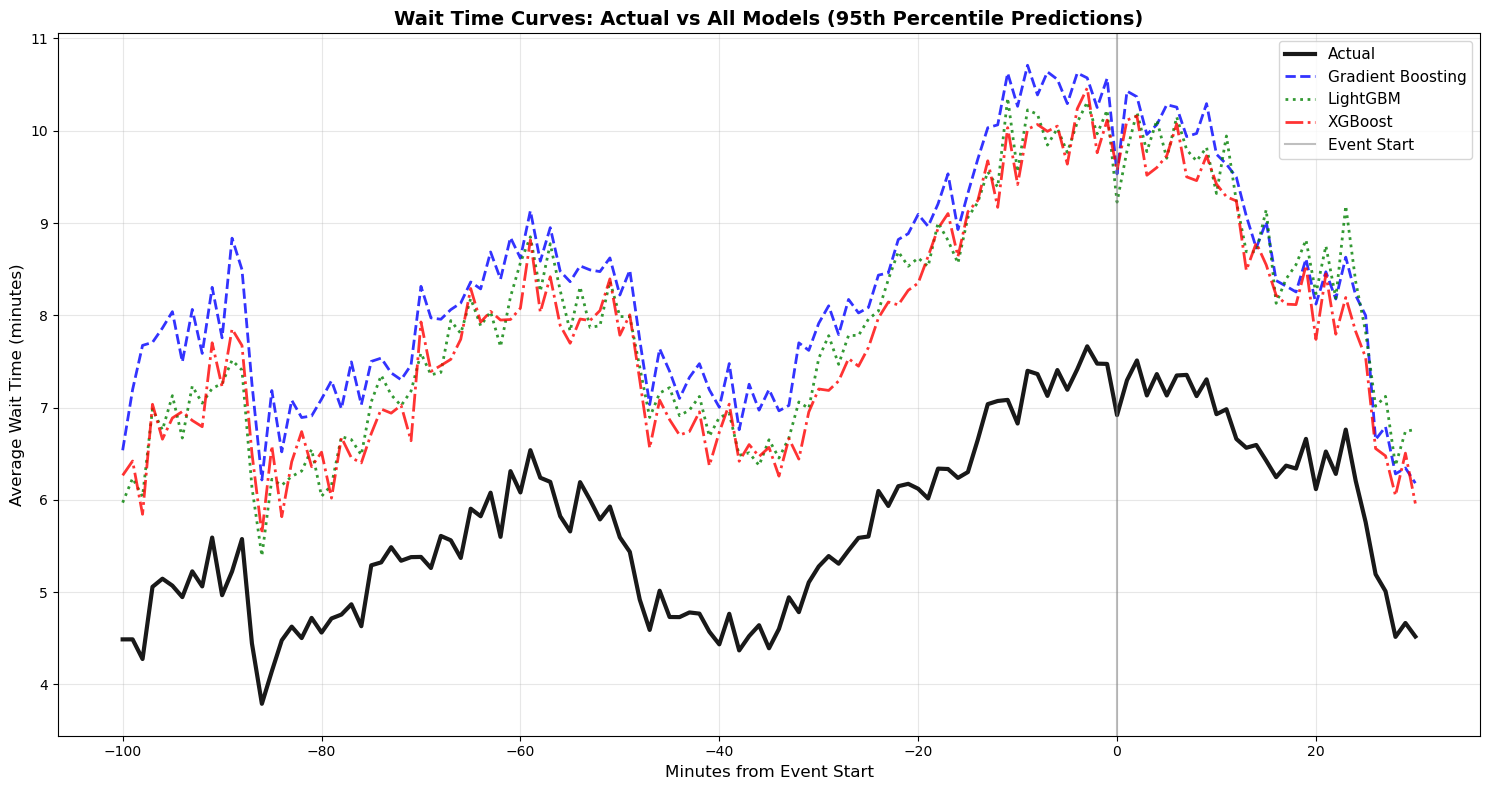

📊 Curve Evaluation Summary:
Time Range: -100 to 30 minutes
Total Time Points: 131
Average Observations per Time Point: 341.8

Mean Absolute Error by Model:
├── Gradient Boosting: 2.60 minutes
├── LightGBM:          2.21 minutes
└── XGBoost:           2.08 minutes


In [ ]:
# Create comprehensive curve evaluation for all three multi-minute models
curve_eval_multi = (
    df_test_multi.groupby('relative start (minutes)')
                 .agg(
                     actual=(target, 'mean'),
                     predicted_gb=('predicted_gb_multi', 'mean'),
                     predicted_lgb=('predicted_lgb_multi', 'mean'),
                     predicted_xgb=('predicted_xgb_multi', 'mean'),
                     count=('event_name', 'count')
                 )
                 .reset_index()
)

# Calculate errors for each model
curve_eval_multi['error_gb'] = np.abs(curve_eval_multi['actual'] - curve_eval_multi['predicted_gb'])
curve_eval_multi['error_lgb'] = np.abs(curve_eval_multi['actual'] - curve_eval_multi['predicted_lgb'])
curve_eval_multi['error_xgb'] = np.abs(curve_eval_multi['actual'] - curve_eval_multi['predicted_xgb'])

# Create the comprehensive comparison plot
plt.figure(figsize=(15, 8))

# Main plot with all models
plt.plot(curve_eval_multi['relative start (minutes)'], curve_eval_multi['actual'], 
         'k-', linewidth=3, label='Actual', alpha=0.9)
plt.plot(curve_eval_multi['relative start (minutes)'], curve_eval_multi['predicted_gb'], 
         '--', linewidth=2, label='Gradient Boosting', alpha=0.8, color='blue')
plt.plot(curve_eval_multi['relative start (minutes)'], curve_eval_multi['predicted_lgb'], 
         ':', linewidth=2, label='LightGBM', alpha=0.8, color='green')
plt.plot(curve_eval_multi['relative start (minutes)'], curve_eval_multi['predicted_xgb'], 
         '-.', linewidth=2, label='XGBoost', alpha=0.8, color='red')

# Add vertical line at event start
plt.axvline(0, color='gray', linestyle='-', alpha=0.5, label='Event Start')

# Formatting
plt.title("Wait Time Curves: Actual vs All Models (95th Percentile Predictions)", fontsize=14, fontweight='bold')
plt.xlabel("Minutes from Event Start", fontsize=12)
plt.ylabel("Average Wait Time (minutes)", fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)

# Add some styling
plt.tight_layout()
plt.show()

# Print summary statistics for the curves
print("📊 Curve Evaluation Summary:")
print("="*50)
print(f"Time Range: {curve_eval_multi['relative start (minutes)'].min():.0f} to {curve_eval_multi['relative start (minutes)'].max():.0f} minutes")
print(f"Total Time Points: {len(curve_eval_multi)}")
print(f"Average Observations per Time Point: {curve_eval_multi['count'].mean():.1f}")
print("\nMean Absolute Error by Model:")
print(f"├── Gradient Boosting: {curve_eval_multi['error_gb'].mean():.2f} minutes")
print(f"├── LightGBM:          {curve_eval_multi['error_lgb'].mean():.2f} minutes")
print(f"└── XGBoost:           {curve_eval_multi['error_xgb'].mean():.2f} minutes")

#### Error Analysis

In [ ]:
# Select core columns to inspect - now including all 3 model predictions
error_diagnostics = df_test_multi[
    ['event_name', 'event_date', 'relative start (minutes)', 'wait time (minutes)', 
     'predicted_gb_multi', 'predicted_lgb_multi', 'predicted_xgb_multi',
     'error_gb_multi', 'error_lgb_multi', 'error_xgb_multi']
    + features  # append all feature columns
].copy()

# Add a column for worst overall error across all models
error_diagnostics['worst_error'] = error_diagnostics[['error_gb_multi', 'error_lgb_multi', 'error_xgb_multi']].max(axis=1)
error_diagnostics['best_error'] = error_diagnostics[['error_gb_multi', 'error_lgb_multi', 'error_xgb_multi']].min(axis=1)

# Sort by worst overall error
error_diagnostics = error_diagnostics.sort_values(by='worst_error', ascending=False)

# Show top 20 worst predictions
print("🔍 Top 20 Worst Predictions (by maximum error across all models):")
print("=" * 80)
display_cols = ['event_name', 'relative start (minutes)', 'wait time (minutes)', 
                'predicted_gb_multi', 'predicted_lgb_multi', 'predicted_xgb_multi',
                'error_gb_multi', 'error_lgb_multi', 'error_xgb_multi', 'worst_error']
print(error_diagnostics[display_cols].head(20))

# Summary statistics
print(f"\n📊 Error Diagnostics Summary:")
print(f"├── Average worst error: {error_diagnostics['worst_error'].mean():.2f} min")
print(f"├── Average best error: {error_diagnostics['best_error'].mean():.2f} min")
print(f"├── Max error overall: {error_diagnostics['worst_error'].max():.2f} min")
print(f"└── Cases where all models agree (error diff < 1 min): {((error_diagnostics['worst_error'] - error_diagnostics['best_error']) < 1).sum()}")

🔍 Top 20 Worst Predictions (by maximum error across all models):
       event_name  relative start (minutes)  relative start (minutes)  \
69383    23BK1112                       -11                       -11   
69225    23BK1112                       -25                       -25   
69630    23BK1112                        11                        11   
69282    23BK1112                       -19                       -19   
69202    23BK1112                       -27                       -27   
69400    23BK1112                        -9                        -9   
152046   24BAAH2                        -22                       -22   
112748   24BA0617                       -56                       -56   
69407    23BK1112                        -9                        -9   
69279    23BK1112                       -20                       -20   
69199    23BK1112                       -27                       -27   
69256    23BK1112                       -22                

In [ ]:
error_diagnostics.to_csv('error_diagnostics_v4.csv', index=False)

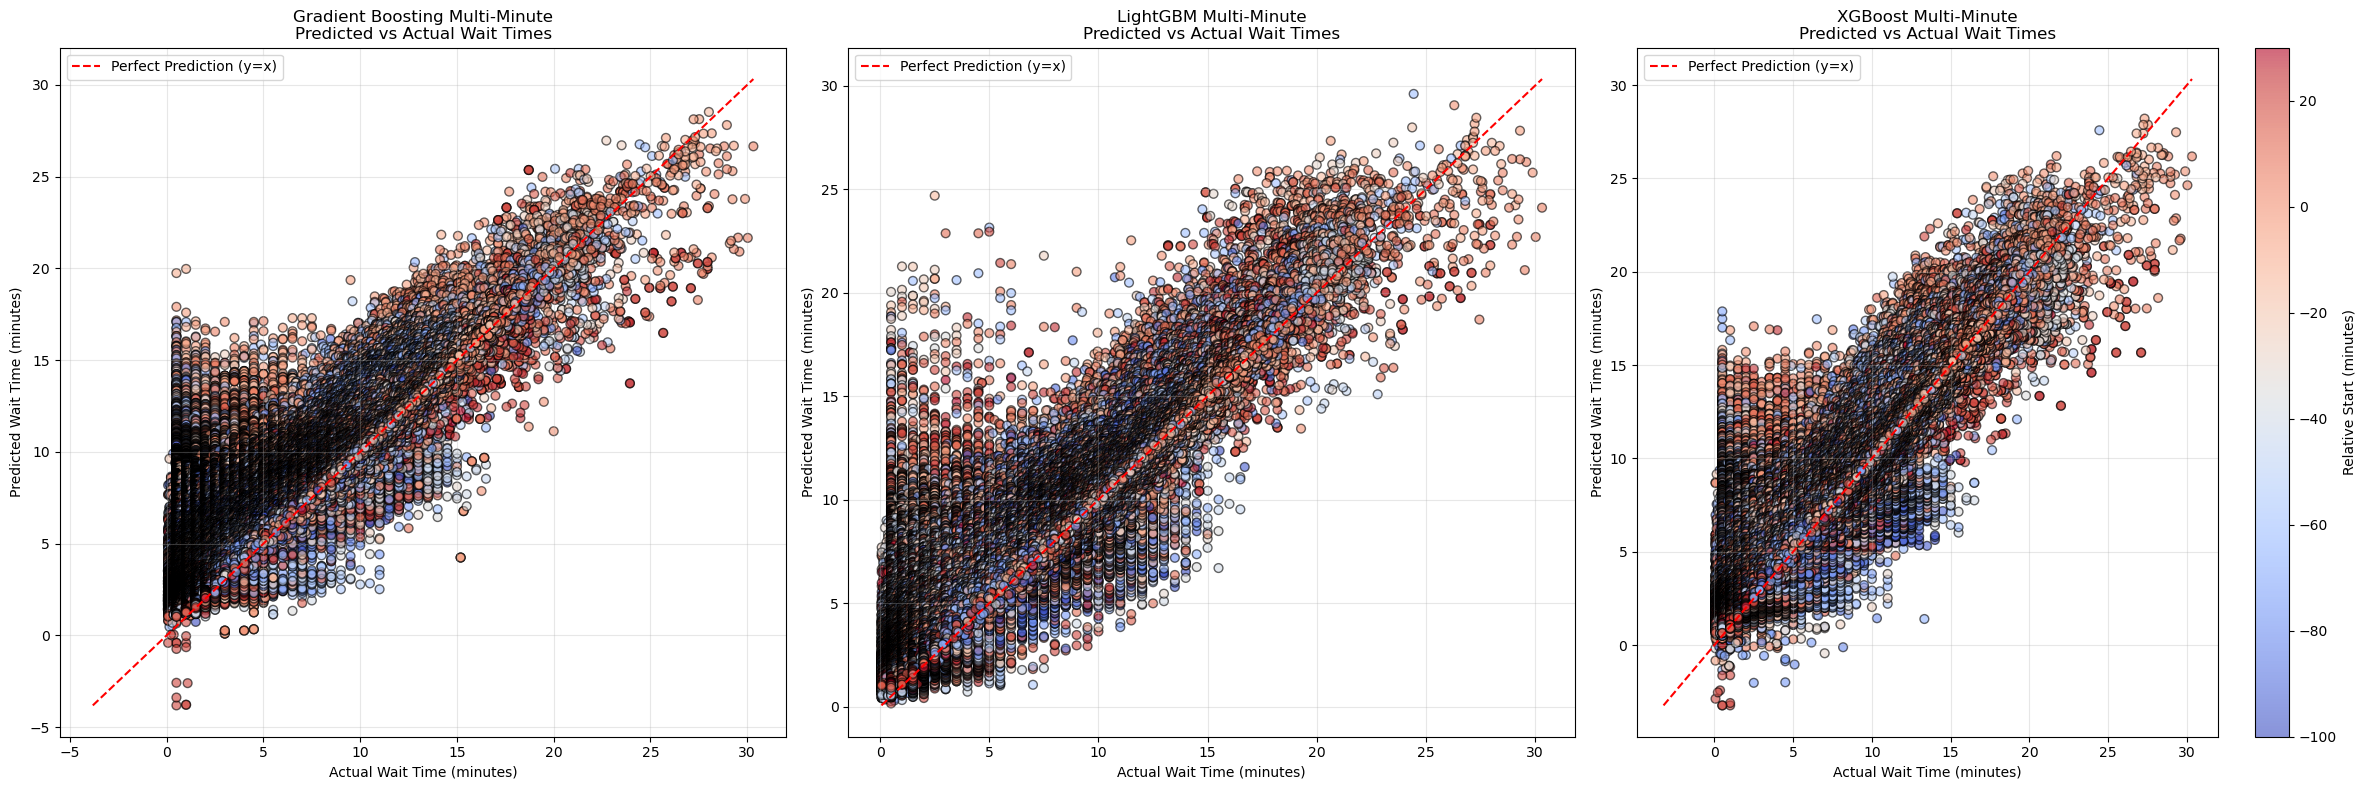

📊 Model Performance Summary:
Gradient Boosting Multi-Minute: MAE = 3.00 min, R² = 0.746
LightGBM Multi-Minute         : MAE = 2.68 min, R² = 0.775
XGBoost Multi-Minute          : MAE = 2.68 min, R² = 0.755


In [ ]:
import matplotlib.pyplot as plt

# Create 3 separate scatter plots for each model
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

models = [
    ('predicted_gb_multi', 'Gradient Boosting Multi-Minute'),
    ('predicted_lgb_multi', 'LightGBM Multi-Minute'), 
    ('predicted_xgb_multi', 'XGBoost Multi-Minute')
]

for idx, (pred_col, model_name) in enumerate(models):
    ax = axes[idx]
    
    # Scatter plot: actual vs predicted
    sc = ax.scatter(
        error_diagnostics['wait time (minutes)'],
        error_diagnostics[pred_col],
        c=error_diagnostics['5_minute_bucket'],
        cmap='coolwarm',
        alpha=0.6,
        edgecolor='k',
        s=40
    )
    
    # Slope=1 reference line
    min_val = min(error_diagnostics['wait time (minutes)'].min(), error_diagnostics[pred_col].min())
    max_val = max(error_diagnostics['wait time (minutes)'].max(), error_diagnostics[pred_col].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction (y=x)')
    
    # Labels and formatting
    ax.set_xlabel('Actual Wait Time (minutes)')
    ax.set_ylabel('Predicted Wait Time (minutes)')
    ax.set_title(f'{model_name}\nPredicted vs Actual Wait Times')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add colorbar to the rightmost plot
    if idx == 2:
        plt.colorbar(sc, ax=ax, label='Relative Start (minutes)')

plt.tight_layout()
plt.show()

# Print summary statistics for each model
print("📊 Model Performance Summary:")
print("="*60)
for pred_col, model_name in models:
    mae = abs(error_diagnostics['wait time (minutes)'] - error_diagnostics[pred_col]).mean()
    r2 = np.corrcoef(error_diagnostics['wait time (minutes)'], error_diagnostics[pred_col])[0, 1]**2
    print(f"{model_name:30s}: MAE = {mae:.2f} min, R² = {r2:.3f}")

### Single Model Quantile - Smooth Curve Approach

In [ ]:
# Single model approach that treats relative start time as a continuous feature
# This should produce smooth curves rather than discrete minute-bucket models

class SingleSmoothQuantileRegressor:
    def __init__(self, quantile=0.95, model_type='gradient_boosting'):
        self.quantile = quantile
        self.model_type = model_type
        self.model = None
        self.preprocessor = None
        self.feature_columns = None

    def fit(self, df, feature_columns, target_column, preprocessor):
        self.feature_columns = feature_columns
        self.preprocessor = preprocessor
        
        X = df[feature_columns]
        y = df[target_column]

        # Use the preprocessor that was already fitted
        X_processed = self.preprocessor.transform(X)
        if hasattr(X_processed, 'toarray'):
            X_processed = X_processed.toarray()

        if self.model_type == 'gradient_boosting':
            self.model = GradientBoostingRegressor(
                loss='quantile',
                alpha=self.quantile,
                n_estimators=100,
                max_depth=6,
                random_state=42
            )
        elif self.model_type == 'lightgbm':
            import lightgbm as lgb
            self.model = lgb.LGBMRegressor(
                objective='quantile',
                alpha=self.quantile,
                n_estimators=100,
                max_depth=6,
                random_state=42,
                verbosity=-1
            )
        elif self.model_type == 'xgboost':
            import xgboost as xgb
            self.model = xgb.XGBRegressor(
                objective='reg:quantileerror',
                quantile_alpha=self.quantile,
                n_estimators=100,
                max_depth=6,
                random_state=42,
                verbosity=0
            )

        self.model.fit(X_processed, y)
        print(f"✅ {self.model_type.title()} single model trained successfully!")

    def predict(self, df):
        X = df[self.feature_columns]
        X_processed = self.preprocessor.transform(X)
        if hasattr(X_processed, 'toarray'):
            X_processed = X_processed.toarray()
        return self.model.predict(X_processed)

#### Train Single Model

In [ ]:
# Train single models for comparison (using the same features and preprocessor)
print("🚀 Training Single Model Quantile Regressors...")

# Use the same features that worked for the multi-model approach
single_features = features.copy()  # This uses the features list from earlier

# Train Gradient Boosting single model
gb_single = SingleSmoothQuantileRegressor(quantile=0.95, model_type='gradient_boosting')
gb_single.fit(df_train, single_features, target, preprocessor)

# Train LightGBM single model  
lgb_single = SingleSmoothQuantileRegressor(quantile=0.95, model_type='lightgbm')
lgb_single.fit(df_train, single_features, target, preprocessor)

# Train XGBoost single model
xgb_single = SingleSmoothQuantileRegressor(quantile=0.95, model_type='xgboost')
xgb_single.fit(df_train, single_features, target, preprocessor)

print("✅ All single models trained!")

🚀 Training Single Model Quantile Regressors...
✅ Gradient_Boosting single model trained successfully!
✅ Lightgbm single model trained successfully!
✅ Xgboost single model trained successfully!
✅ All single models trained!


In [ ]:
# Make predictions with all single models
df_test_single = df.iloc[test_idx].copy()

df_test_single['predicted_gb_single'] = gb_single.predict(df_test_single)
df_test_single['predicted_lgb_single'] = lgb_single.predict(df_test_single)
df_test_single['predicted_xgb_single'] = xgb_single.predict(df_test_single)

# Calculate errors
df_test_single['error_gb_single'] = np.abs(df_test_single[target] - df_test_single['predicted_gb_single'])
df_test_single['error_lgb_single'] = np.abs(df_test_single[target] - df_test_single['predicted_lgb_single'])
df_test_single['error_xgb_single'] = np.abs(df_test_single[target] - df_test_single['predicted_xgb_single'])

print("✅ Predictions completed for all single models!")

✅ Predictions completed for all single models!


In [ ]:
# Evaluate single model performance
def evaluate_single_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    coverage = np.mean(y_true <= y_pred) * 100
    
    alpha = 0.95
    pinball = np.mean(
        np.where(y_true >= y_pred,
                 alpha * (y_true - y_pred),
                 (1 - alpha) * (y_pred - y_true))
    )
    
    over_pred_rate = np.mean(y_pred > y_true) * 100
    avg_buffer = np.mean(y_pred[y_pred > y_true] - y_true[y_pred > y_true])
    
    print(f"\n📊 {model_name} Single Model Metrics (Q95)")
    print(f"{'─' * 50}")
    print(f"Mean Absolute Error (MAE):       {mae:.2f} min")
    print(f"Coverage:                        {coverage:.2f}%")
    print(f"Pinball Loss:                    {pinball:.4f}")
    print(f"Over-Prediction Rate:            {over_pred_rate:.2f}%")
    print(f"Average Safety Buffer:           {avg_buffer:.2f} min")
    
    return {'mae': mae, 'coverage': coverage, 'pinball': pinball, 
            'over_pred_rate': over_pred_rate, 'avg_buffer': avg_buffer}

# Evaluate all single models
y_true_single = df_test_single[target]

results_gb_single = evaluate_single_model(y_true_single, df_test_single['predicted_gb_single'], 'Gradient Boosting')
results_lgb_single = evaluate_single_model(y_true_single, df_test_single['predicted_lgb_single'], 'LightGBM')
results_xgb_single = evaluate_single_model(y_true_single, df_test_single['predicted_xgb_single'], 'XGBoost')


📊 Gradient Boosting Single Model Metrics (Q95)
──────────────────────────────────────────────────
Mean Absolute Error (MAE):       2.75 min
Coverage:                        91.85%
Pinball Loss:                    0.2211
Over-Prediction Rate:            91.85%
Average Safety Buffer:           2.90 min

📊 LightGBM Single Model Metrics (Q95)
──────────────────────────────────────────────────
Mean Absolute Error (MAE):       2.78 min
Coverage:                        92.15%
Pinball Loss:                    0.2310
Over-Prediction Rate:            92.15%
Average Safety Buffer:           2.91 min

📊 XGBoost Single Model Metrics (Q95)
──────────────────────────────────────────────────
Mean Absolute Error (MAE):       2.39 min
Coverage:                        89.72%
Pinball Loss:                    0.2415
Over-Prediction Rate:            89.72%
Average Safety Buffer:           2.52 min


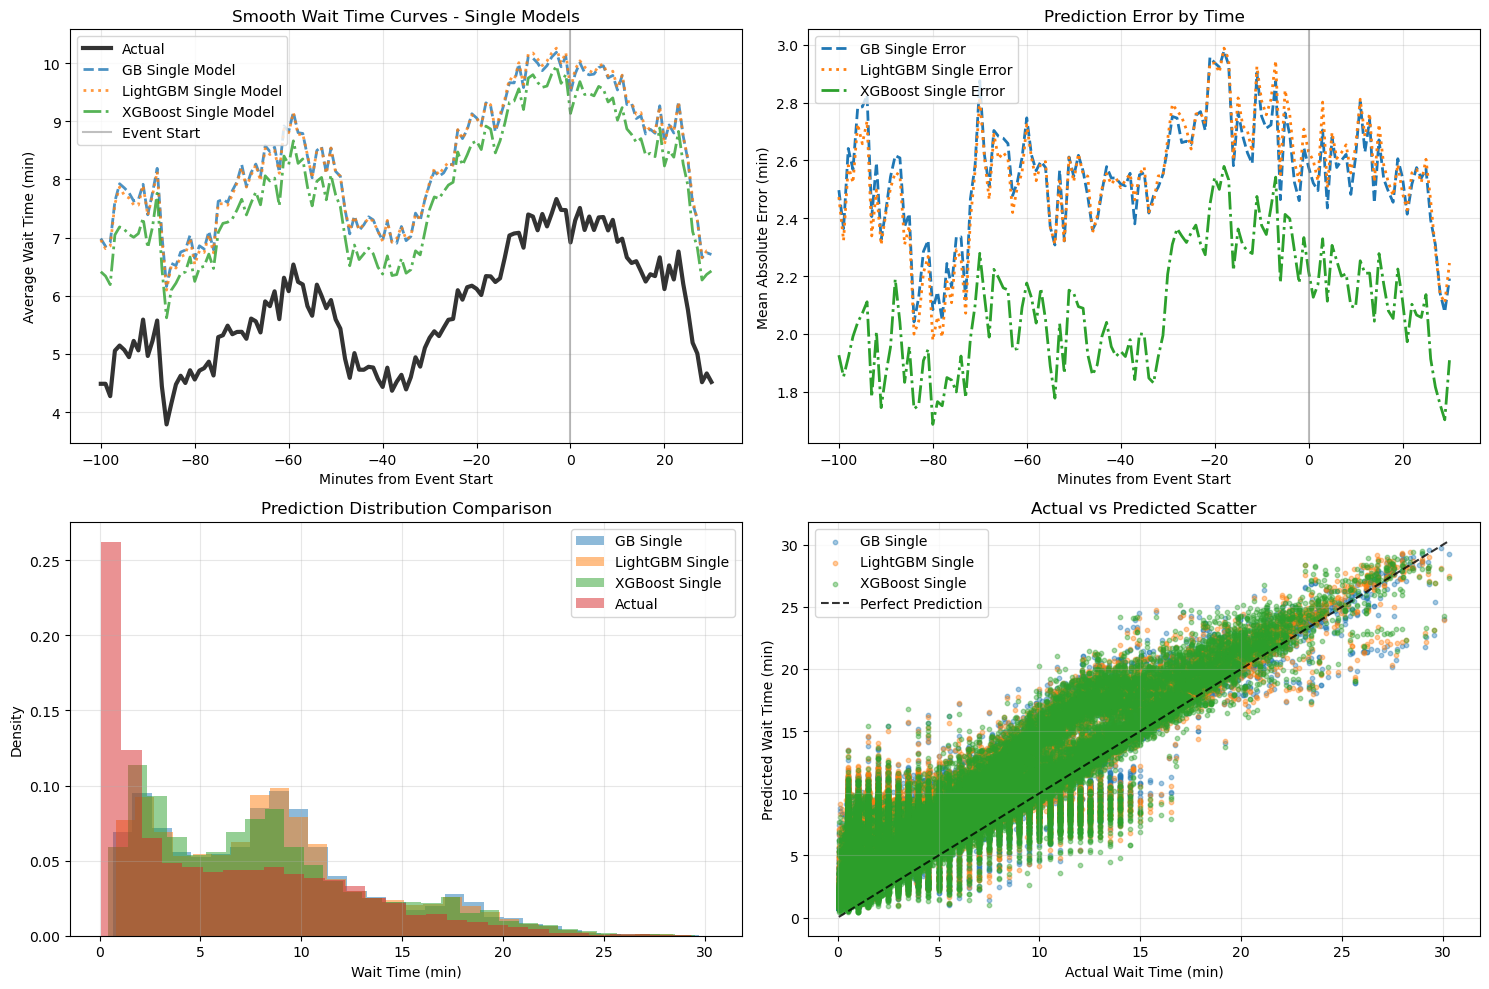

In [ ]:
# Create smooth curves for comparison
def create_smooth_curves():
    # Generate curves by averaging predictions across all events for each minute
    curve_data = []
    
    for minute in sorted(df_test_single['relative start (minutes)'].unique()):
        single_data = df_test_single[df_test_single['relative start (minutes)'] == minute]
        multi_data = df_test_multi[df_test_multi['relative start (minutes)'] == minute]
        
        if len(single_data) > 0 and len(multi_data) > 0:
            curve_data.append({
                'minute': minute,
                'actual': single_data[target].mean(),
                'gb_single': single_data['predicted_gb_single'].mean(),
                'lgb_single': single_data['predicted_lgb_single'].mean(),
                'xgb_single': single_data['predicted_xgb_single'].mean(),
                'gb_multi': multi_data['predicted_gb_multi'].mean(),
                'lgb_multi': multi_data['predicted_lgb_multi'].mean(),
                'xgb_multi': multi_data['predicted_xgb_multi'].mean(),
                'n_observations': len(single_data)
            })
    
    return pd.DataFrame(curve_data)

curve_df = create_smooth_curves()

# Plot smooth curves
plt.figure(figsize=(15, 10))

# Main comparison plot
plt.subplot(2, 2, 1)
plt.plot(curve_df['minute'], curve_df['actual'], 'k-', linewidth=3, label='Actual', alpha=0.8)
plt.plot(curve_df['minute'], curve_df['gb_single'], '--', linewidth=2, label='GB Single Model', alpha=0.8)
plt.plot(curve_df['minute'], curve_df['lgb_single'], ':', linewidth=2, label='LightGBM Single Model', alpha=0.8)
plt.plot(curve_df['minute'], curve_df['xgb_single'], '-.', linewidth=2, label='XGBoost Single Model', alpha=0.8)
plt.axvline(0, color='gray', linestyle='-', alpha=0.5, label='Event Start')
plt.xlabel('Minutes from Event Start')
plt.ylabel('Average Wait Time (min)')
plt.title('Smooth Wait Time Curves - Single Models')
plt.legend()
plt.grid(True, alpha=0.3)

# Error comparison
plt.subplot(2, 2, 2)
curve_df['error_gb'] = np.abs(curve_df['actual'] - curve_df['gb_single'])
curve_df['error_lgb'] = np.abs(curve_df['actual'] - curve_df['lgb_single'])
curve_df['error_xgb'] = np.abs(curve_df['actual'] - curve_df['xgb_single'])

plt.plot(curve_df['minute'], curve_df['error_gb'], '--', linewidth=2, label='GB Single Error')
plt.plot(curve_df['minute'], curve_df['error_lgb'], ':', linewidth=2, label='LightGBM Single Error')
plt.plot(curve_df['minute'], curve_df['error_xgb'], '-.', linewidth=2, label='XGBoost Single Error')
plt.axvline(0, color='gray', linestyle='-', alpha=0.5)
plt.xlabel('Minutes from Event Start')
plt.ylabel('Mean Absolute Error (min)')
plt.title('Prediction Error by Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Distribution of predictions
plt.subplot(2, 2, 3)
plt.hist(df_test_single['predicted_gb_single'], bins=30, alpha=0.5, label='GB Single', density=True)
plt.hist(df_test_single['predicted_lgb_single'], bins=30, alpha=0.5, label='LightGBM Single', density=True)
plt.hist(df_test_single['predicted_xgb_single'], bins=30, alpha=0.5, label='XGBoost Single', density=True)
plt.hist(df_test_single[target], bins=30, alpha=0.5, label='Actual', density=True)
plt.xlabel('Wait Time (min)')
plt.ylabel('Density')
plt.title('Prediction Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Actual vs Predicted scatter
plt.subplot(2, 2, 4)
plt.scatter(df_test_single[target], df_test_single['predicted_gb_single'], alpha=0.4, s=10, label='GB Single')
plt.scatter(df_test_single[target], df_test_single['predicted_lgb_single'], alpha=0.4, s=10, label='LightGBM Single')
plt.scatter(df_test_single[target], df_test_single['predicted_xgb_single'], alpha=0.4, s=10, label='XGBoost Single')

min_val = df_test_single[target].min()
max_val = df_test_single[target].max()
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='Perfect Prediction')
plt.xlabel('Actual Wait Time (min)')
plt.ylabel('Predicted Wait Time (min)')
plt.title('Actual vs Predicted Scatter')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Comprehensive Model Comparison: Multi-Minute vs Single Models

In [ ]:
# 1. EVALUATION METRICS COMPARISON
# Create comprehensive comparison table for all models

def create_model_comparison_table():
    """Create a comprehensive comparison table of all model metrics"""
    
    # Collect metrics for multi-minute models
    multi_metrics = {
        'Gradient Boosting Multi': evaluate_model(y_true_multi, df_test_multi['predicted_gb_multi'], 'GB Multi'),
        'LightGBM Multi': evaluate_model(y_true_multi, df_test_multi['predicted_lgb_multi'], 'LGB Multi'),
        'XGBoost Multi': evaluate_model(y_true_multi, df_test_multi['predicted_xgb_multi'], 'XGB Multi')
    }
    
    # Collect metrics for single models
    single_metrics = {
        'Gradient Boosting Single': evaluate_single_model(y_true_single, df_test_single['predicted_gb_single'], 'GB Single'),
        'LightGBM Single': evaluate_single_model(y_true_single, df_test_single['predicted_lgb_single'], 'LGB Single'),
        'XGBoost Single': evaluate_single_model(y_true_single, df_test_single['predicted_xgb_single'], 'XGB Single')
    }
    
    # Combine all metrics
    all_metrics = {**multi_metrics, **single_metrics}
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(all_metrics).T
    comparison_df['model_type'] = ['Multi', 'Multi', 'Multi', 'Single', 'Single', 'Single']
    comparison_df['algorithm'] = ['Gradient Boosting', 'LightGBM', 'XGBoost', 'Gradient Boosting', 'LightGBM', 'XGBoost']
    
    return comparison_df

# Create and display comparison table
print("🔍 COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)
comparison_table = create_model_comparison_table()

# Display formatted comparison
pd.set_option('display.float_format', '{:.3f}'.format)
print(comparison_table[['model_type', 'algorithm', 'mae', 'coverage', 'pinball', 'over_pred_rate', 'avg_buffer']])

# Reset display options
pd.reset_option('display.float_format')

🔍 COMPREHENSIVE MODEL COMPARISON

📊 GB Multi Multi-Minute Model Metrics (Q95)
───────────────────────────────────────────────────────
Mean Absolute Error (MAE):       3.00 min
Coverage:                        86.82%
Pinball Loss:                    0.3238
Over-Prediction Rate:            86.82%
Average Safety Buffer:           3.24 min

📊 LGB Multi Multi-Minute Model Metrics (Q95)
───────────────────────────────────────────────────────
Mean Absolute Error (MAE):       2.68 min
Coverage:                        85.65%
Pinball Loss:                    0.3173
Over-Prediction Rate:            85.65%
Average Safety Buffer:           2.89 min

📊 XGB Multi Multi-Minute Model Metrics (Q95)
───────────────────────────────────────────────────────
Mean Absolute Error (MAE):       2.68 min
Coverage:                        83.24%
Pinball Loss:                    0.3812
Over-Prediction Rate:            83.24%
Average Safety Buffer:           2.89 min

📊 GB Single Single Model Metrics (Q95)
──────────

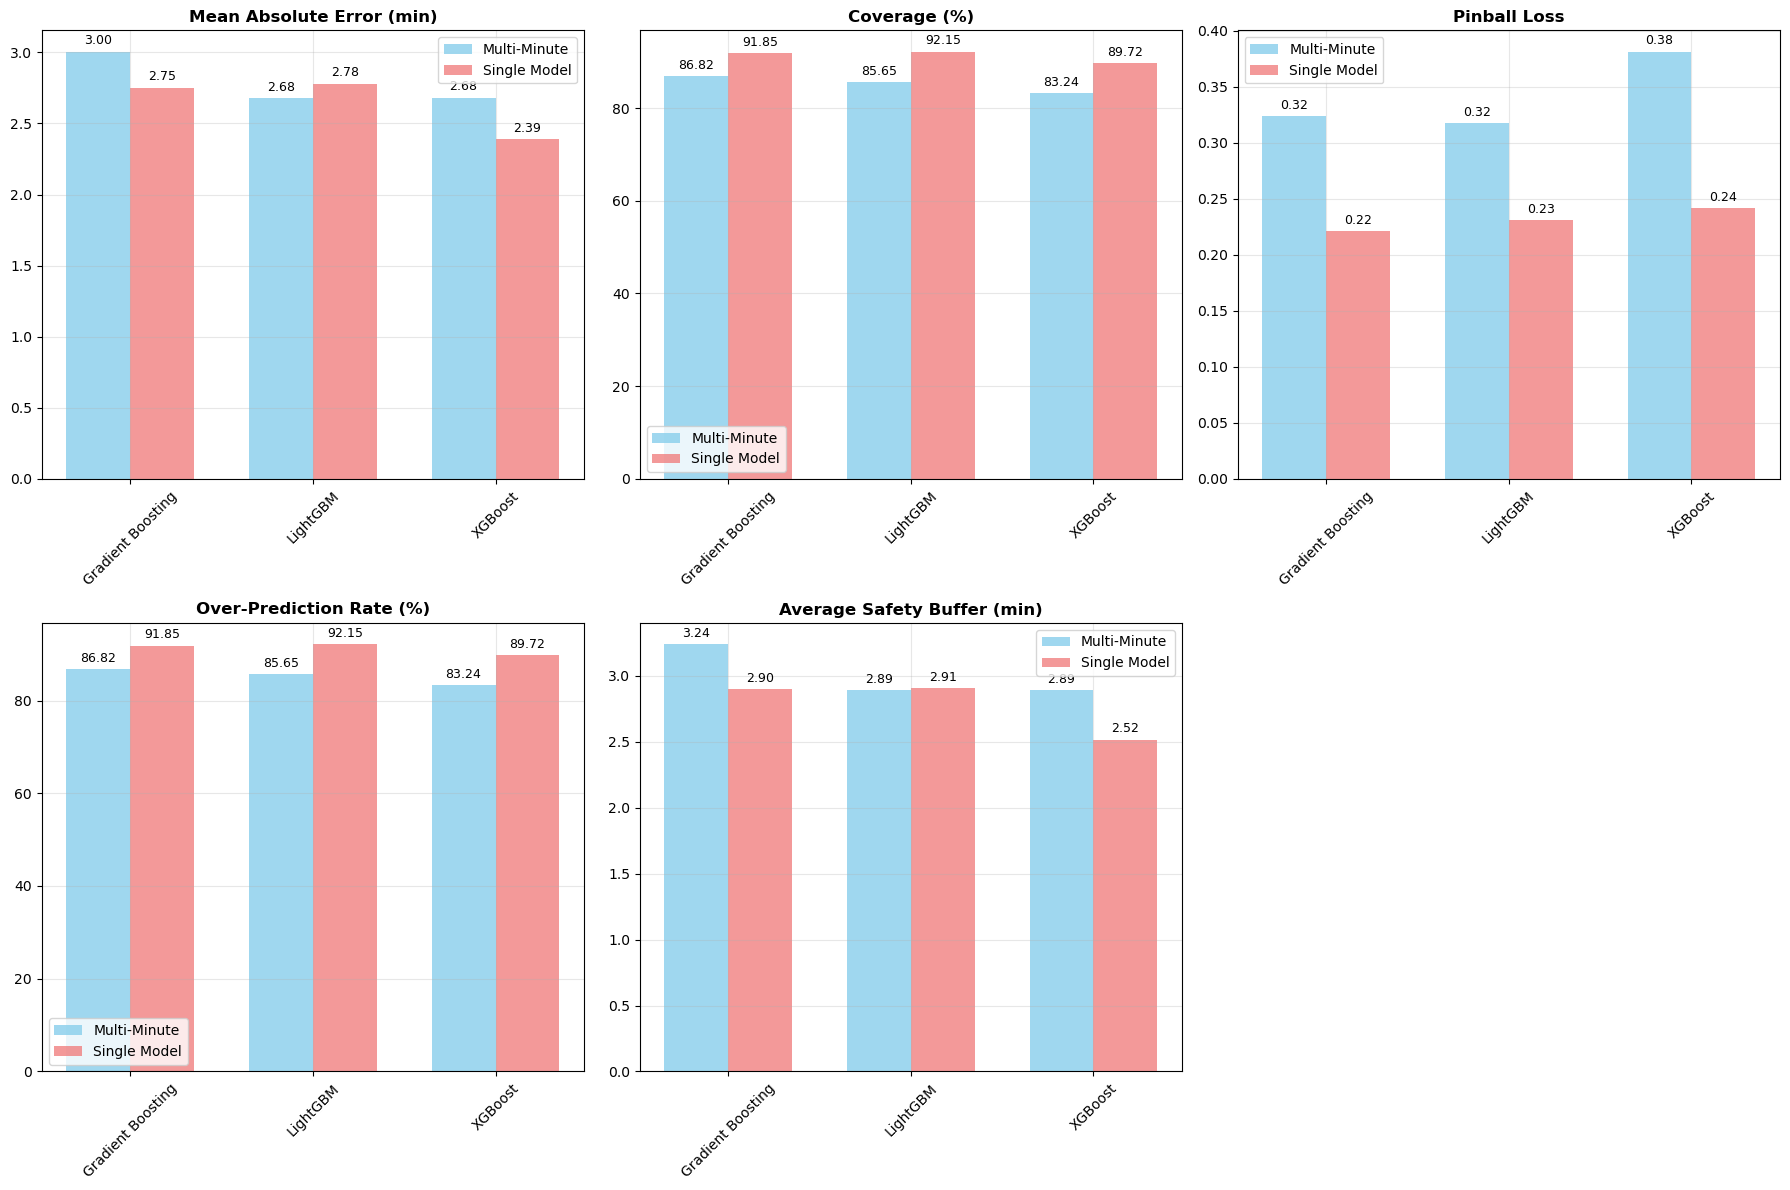


🏆 PERFORMANCE WINNERS BY METRIC:
--------------------------------------------------
MAE                 : XGBoost Single            (2.392)
PINBALL             : Gradient Boosting Single  (0.221)
OVER_PRED_RATE      : XGBoost Multi             (83.244)


In [ ]:
# Create visualization of metrics comparison
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

metrics_to_plot = ['mae', 'coverage', 'pinball', 'over_pred_rate', 'avg_buffer']
metric_titles = ['Mean Absolute Error (min)', 'Coverage (%)', 'Pinball Loss', 'Over-Prediction Rate (%)', 'Average Safety Buffer (min)']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, metric_titles)):
    ax = axes[idx]
    
    # Prepare data for plotting
    plot_data = comparison_table.reset_index()
    plot_data['Model'] = plot_data['algorithm'] + ' ' + plot_data['model_type']
    
    # Create grouped bar plot
    gb_data = plot_data[plot_data['algorithm'] == 'Gradient Boosting']
    lgb_data = plot_data[plot_data['algorithm'] == 'LightGBM']
    xgb_data = plot_data[plot_data['algorithm'] == 'XGBoost']
    
    x = np.arange(3)  # Three algorithms
    width = 0.35
    
    multi_values = [gb_data[gb_data['model_type'] == 'Multi'][metric].iloc[0],
                   lgb_data[lgb_data['model_type'] == 'Multi'][metric].iloc[0],
                   xgb_data[xgb_data['model_type'] == 'Multi'][metric].iloc[0]]
    
    single_values = [gb_data[gb_data['model_type'] == 'Single'][metric].iloc[0],
                    lgb_data[lgb_data['model_type'] == 'Single'][metric].iloc[0],
                    xgb_data[xgb_data['model_type'] == 'Single'][metric].iloc[0]]
    
    bars1 = ax.bar(x - width/2, multi_values, width, label='Multi-Minute', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x + width/2, single_values, width, label='Single Model', alpha=0.8, color='lightcoral')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(multi_values + single_values),
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(multi_values + single_values),
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_title(title, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Gradient Boosting', 'LightGBM', 'XGBoost'], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove the extra subplot
axes[5].remove()

plt.tight_layout()
plt.show()

# Print winner summary
print("\n🏆 PERFORMANCE WINNERS BY METRIC:")
print("-" * 50)
for metric in ['mae', 'pinball', 'over_pred_rate']:  # Focus on key metrics
    winner = comparison_table[metric].idxmin()
    value = comparison_table.loc[winner, metric]
    print(f"{metric.upper():20s}: {winner:25s} ({value:.3f})")

🔍 FEATURE IMPORTANCE ANALYSIS


<Figure size 1600x1000 with 0 Axes>

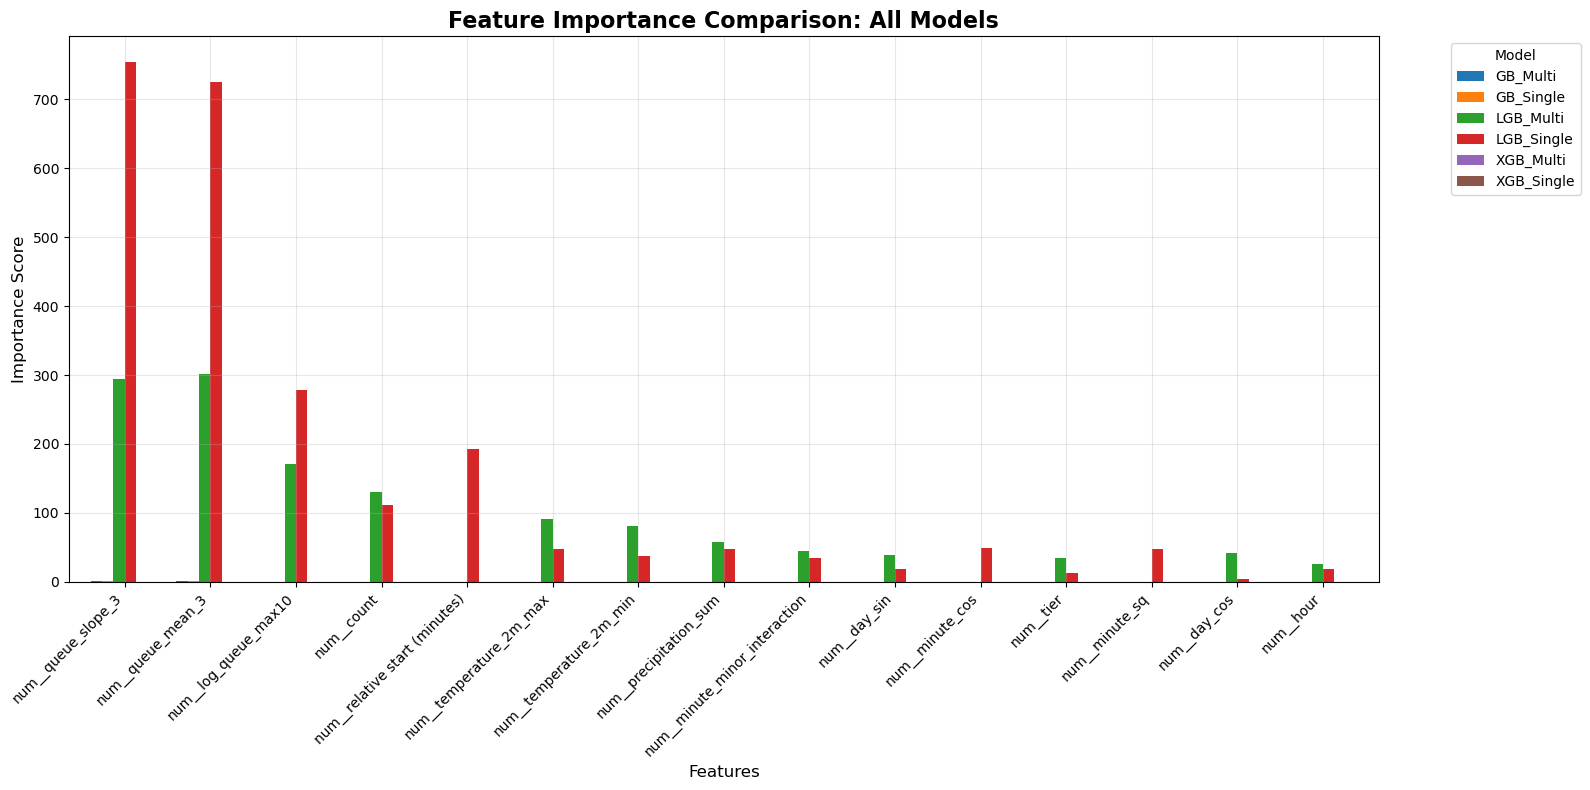


📊 TOP 10 FEATURES BY MODEL:
------------------------------------------------------------

GB_Single:
  num__queue_slope_3                      : 0.4301
  num__queue_mean_3                       : 0.4236
  num__log_queue_max10                    : 0.0540
  num__count                              : 0.0106
  num__minute_sq                          : 0.0086
  num__minute_minor_interaction           : 0.0077
  num__relative start (minutes)           : 0.0050
  num__precipitation_sum                  : 0.0037
  cat__team_chase atlantic                : 0.0032
  num__minute_sin                         : 0.0032

LGB_Single:
  num__queue_slope_3                      : 754.0000
  num__queue_mean_3                       : 726.0000
  num__log_queue_max10                    : 278.0000
  num__relative start (minutes)           : 192.0000
  num__count                              : 111.0000
  num__minute_cos                         : 49.0000
  num__precipitation_sum                  : 48.0000
  num_

In [ ]:
# 2. FEATURE IMPORTANCE ANALYSIS
# Extract feature importance for all models

def extract_feature_importance(model, model_name, feature_names):
    """Extract feature importance from trained models"""
    try:
        if hasattr(model.model, 'feature_importances_'):
            importance = model.model.feature_importances_
        elif hasattr(model.model, 'coef_'):
            importance = np.abs(model.model.coef_)
        else:
            print(f"Cannot extract feature importance for {model_name}")
            return None
        
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance,
            'model': model_name
        }).sort_values('importance', ascending=False)
        
        return importance_df
    except Exception as e:
        print(f"Error extracting importance for {model_name}: {e}")
        return None

# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Extract importance for all models
importance_data = []

# Single models
for model, name in [(gb_single, 'GB_Single'), (lgb_single, 'LGB_Single'), (xgb_single, 'XGB_Single')]:
    imp_df = extract_feature_importance(model, name, feature_names)
    if imp_df is not None:
        importance_data.append(imp_df)

# Multi models - take average importance across all minute buckets
def extract_multi_model_importance(multi_model, model_name, feature_names):
    """Extract average feature importance across all minute bucket models"""
    all_importances = []
    
    for minute, model in multi_model.models.items():
        if hasattr(model, 'feature_importances_'):
            all_importances.append(model.feature_importances_)
    
    if all_importances:
        avg_importance = np.mean(all_importances, axis=0)
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': avg_importance,
            'model': model_name
        }).sort_values('importance', ascending=False)
        return importance_df
    else:
        print(f"No feature importances found for {model_name}")
        return None

# Multi models
for model, name in [(gb_multi, 'GB_Multi'), (lgb_multi, 'LGB_Multi'), (xgb_multi, 'XGB_Multi')]:
    imp_df = extract_multi_model_importance(model, name, feature_names)
    if imp_df is not None:
        importance_data.append(imp_df)

# Combine all importance data
if importance_data:
    all_importance = pd.concat(importance_data, ignore_index=True)
    
    # Create feature importance comparison plot
    plt.figure(figsize=(16, 10))
    
    # Get top 15 features by average importance
    avg_importance = all_importance.groupby('feature')['importance'].mean().sort_values(ascending=False)
    top_features = avg_importance.head(15).index
    
    # Filter data for top features
    plot_data = all_importance[all_importance['feature'].isin(top_features)]
    
    # Create grouped bar plot
    pivot_data = plot_data.pivot(index='feature', columns='model', values='importance')
    pivot_data = pivot_data.reindex(top_features)  # Maintain order
    
    ax = pivot_data.plot(kind='bar', figsize=(16, 8), width=0.8)
    plt.title('Feature Importance Comparison: All Models', fontsize=16, fontweight='bold')
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance Score', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print top 10 features for each model
    print("\n📊 TOP 10 FEATURES BY MODEL:")
    print("-" * 60)
    for model_name in all_importance['model'].unique():
        model_imp = all_importance[all_importance['model'] == model_name].head(10)
        print(f"\n{model_name}:")
        for idx, row in model_imp.iterrows():
            print(f"  {row['feature']:40s}: {row['importance']:.4f}")

🔍 ERROR DIAGNOSTIC COMPARISON
📊 ERROR COMPARISON SUMMARY:
----------------------------------------

GB Algorithm:
  Single Model Wins: 25551/44773 (57.1%)
  Multi Model Wins:  19222/44773 (42.9%)
  Avg Error Single:  2.75 min
  Avg Error Multi:   3.00 min
  Error Difference:  -0.25 min

LGB Algorithm:
  Single Model Wins: 20091/44773 (44.9%)
  Multi Model Wins:  24682/44773 (55.1%)
  Avg Error Single:  2.78 min
  Avg Error Multi:   2.68 min
  Error Difference:  0.10 min

XGB Algorithm:
  Single Model Wins: 25590/44773 (57.2%)
  Multi Model Wins:  19183/44773 (42.8%)
  Avg Error Single:  2.39 min
  Avg Error Multi:   2.68 min
  Error Difference:  -0.29 min


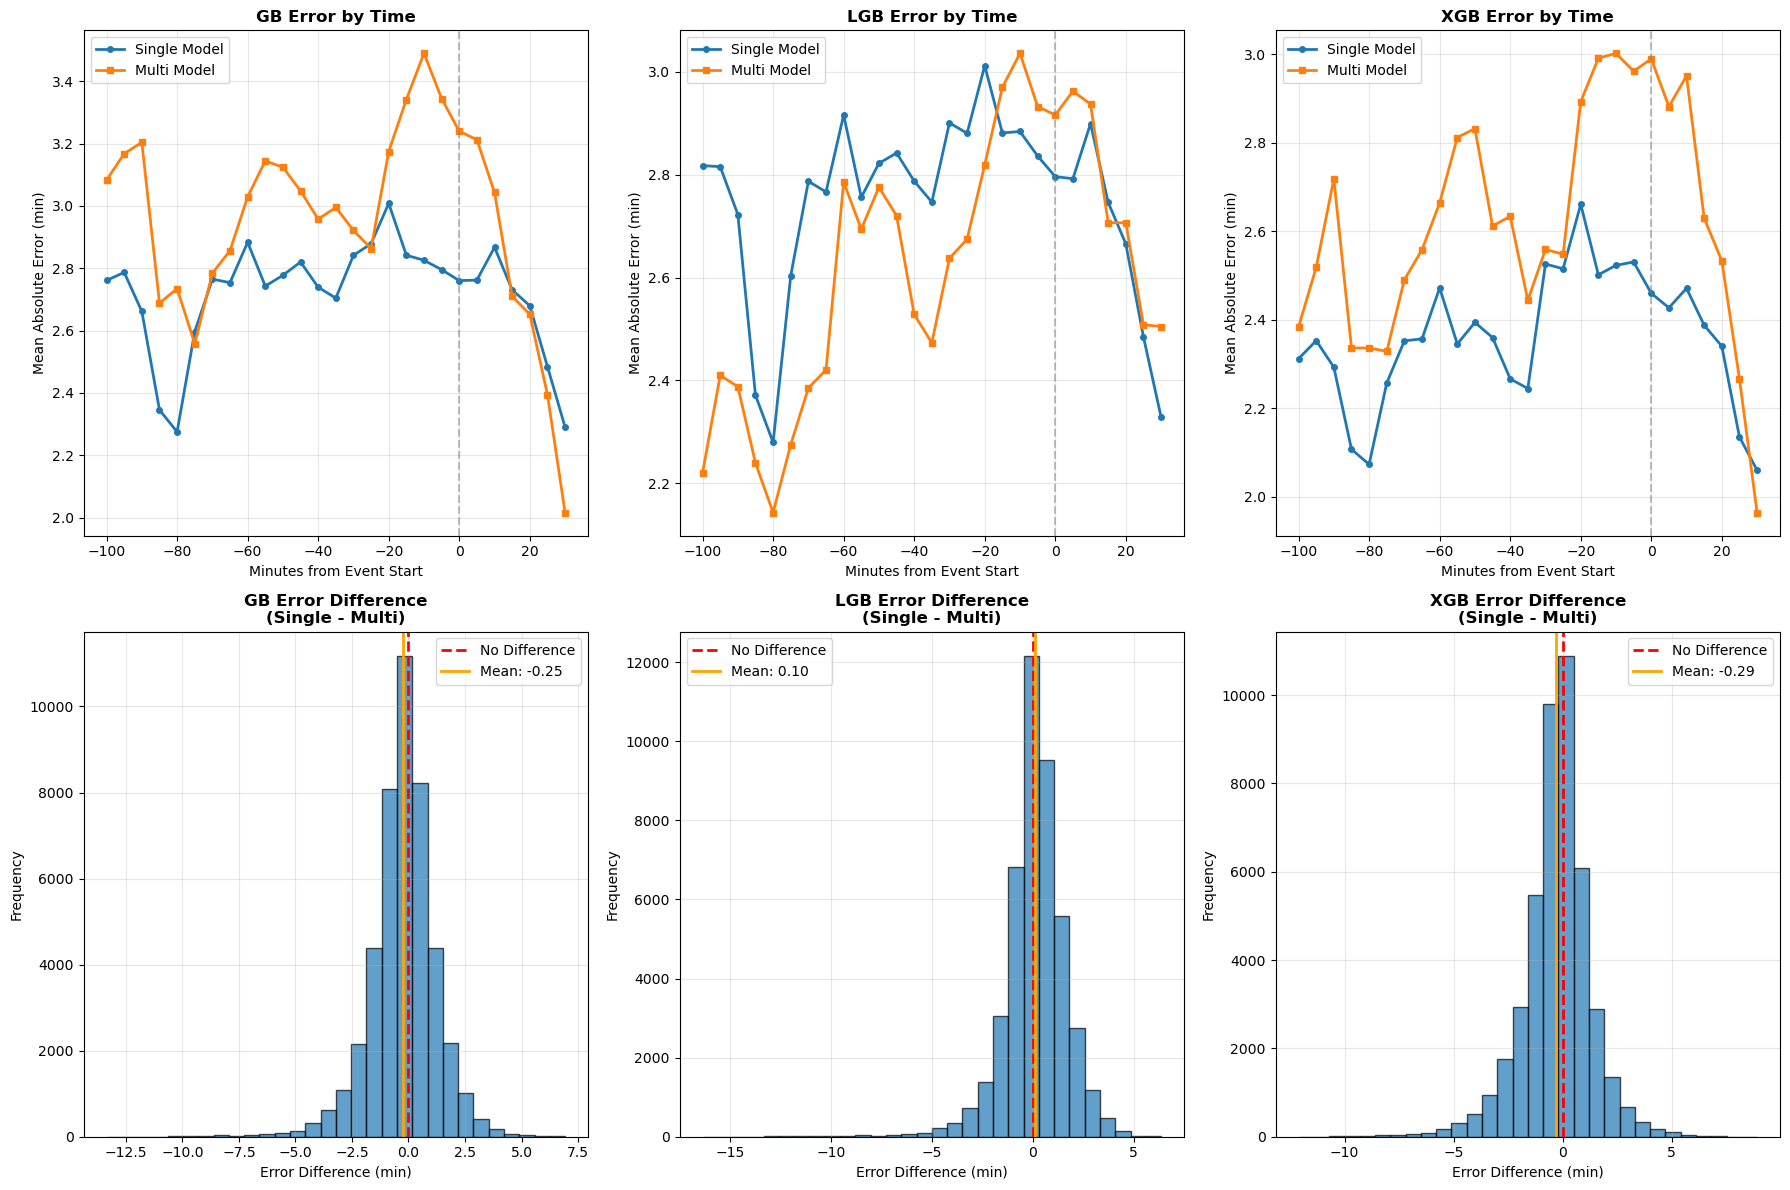


🚨 WORST CASE ANALYSIS:
----------------------------------------

GB Algorithm:
  Worst Single Model Predictions:
    23BK1112                       | Time:   5 | Actual:  1.5 | Pred: 14.6 | Error: 13.1
    23BK1112                       | Time:  -9 | Actual:  0.5 | Pred: 13.5 | Error: 13.0
    23BK1112                       | Time:   6 | Actual:  2.5 | Pred: 15.4 | Error: 12.9
    23BK1112                       | Time: -11 | Actual:  1.5 | Pred: 13.8 | Error: 12.3
    23BK1112                       | Time: -12 | Actual:  0.5 | Pred: 12.6 | Error: 12.1
  Worst Multi Model Predictions:
    23BK1112                       | Time:  -9 | Actual:  0.5 | Pred: 19.7 | Error: 19.2
    23BK1112                       | Time:  -9 | Actual:  1.0 | Pred: 20.0 | Error: 19.0
    24LB0820                       | Time:   1 | Actual:  0.5 | Pred: 17.9 | Error: 17.4
    24BA0218                       | Time:   1 | Actual:  0.5 | Pred: 17.2 | Error: 16.7
    24BA0218                       | Time:  -3 | Act

In [ ]:
# 3. ERROR DIAGNOSTIC COMPARISON
# Compare error patterns between multi-minute and single models

print("🔍 ERROR DIAGNOSTIC COMPARISON")
print("=" * 70)

# Merge single and multi predictions for comparison
df_comparison = df_test_single[['event_name', 'event_date', 'relative start (minutes)', target]].copy()

# Add all predictions
df_comparison['gb_single'] = df_test_single['predicted_gb_single']
df_comparison['lgb_single'] = df_test_single['predicted_lgb_single'] 
df_comparison['xgb_single'] = df_test_single['predicted_xgb_single']

# Merge multi predictions (ensure same indices)
multi_predictions = df_test_multi[['predicted_gb_multi', 'predicted_lgb_multi', 'predicted_xgb_multi']].copy()
multi_predictions.index = df_test_single.index  # Align indices
df_comparison = pd.concat([df_comparison, multi_predictions], axis=1)

# Calculate errors
df_comparison['error_gb_single'] = np.abs(df_comparison[target] - df_comparison['gb_single'])
df_comparison['error_lgb_single'] = np.abs(df_comparison[target] - df_comparison['lgb_single'])
df_comparison['error_xgb_single'] = np.abs(df_comparison[target] - df_comparison['xgb_single'])

df_comparison['error_gb_multi'] = np.abs(df_comparison[target] - df_comparison['predicted_gb_multi'])
df_comparison['error_lgb_multi'] = np.abs(df_comparison[target] - df_comparison['predicted_lgb_multi'])
df_comparison['error_xgb_multi'] = np.abs(df_comparison[target] - df_comparison['predicted_xgb_multi'])

# Calculate which approach is better for each prediction
df_comparison['gb_winner'] = np.where(df_comparison['error_gb_single'] < df_comparison['error_gb_multi'], 'Single', 'Multi')
df_comparison['lgb_winner'] = np.where(df_comparison['error_lgb_single'] < df_comparison['error_lgb_multi'], 'Single', 'Multi')
df_comparison['xgb_winner'] = np.where(df_comparison['error_xgb_single'] < df_comparison['error_xgb_multi'], 'Single', 'Multi')

# Summary statistics
print("📊 ERROR COMPARISON SUMMARY:")
print("-" * 40)
for algo in ['gb', 'lgb', 'xgb']:
    single_wins = (df_comparison[f'{algo}_winner'] == 'Single').sum()
    multi_wins = (df_comparison[f'{algo}_winner'] == 'Multi').sum()
    total = len(df_comparison)
    
    avg_error_single = df_comparison[f'error_{algo}_single'].mean()
    avg_error_multi = df_comparison[f'error_{algo}_multi'].mean()
    
    print(f"\n{algo.upper()} Algorithm:")
    print(f"  Single Model Wins: {single_wins}/{total} ({single_wins/total*100:.1f}%)")
    print(f"  Multi Model Wins:  {multi_wins}/{total} ({multi_wins/total*100:.1f}%)")
    print(f"  Avg Error Single:  {avg_error_single:.2f} min")
    print(f"  Avg Error Multi:   {avg_error_multi:.2f} min")
    print(f"  Error Difference:  {avg_error_single - avg_error_multi:.2f} min")

# Error distribution by time
plt.figure(figsize=(18, 12))

# Error by relative start time
for idx, algo in enumerate(['gb', 'lgb', 'xgb']):
    plt.subplot(2, 3, idx + 1)
    
    # Group by 5-minute buckets for cleaner visualization
    df_comparison['time_bucket'] = (df_comparison['relative start (minutes)'] // 5) * 5
    error_by_time = df_comparison.groupby('time_bucket').agg({
        f'error_{algo}_single': 'mean',
        f'error_{algo}_multi': 'mean'
    }).reset_index()
    
    plt.plot(error_by_time['time_bucket'], error_by_time[f'error_{algo}_single'], 
             'o-', label='Single Model', linewidth=2, markersize=4)
    plt.plot(error_by_time['time_bucket'], error_by_time[f'error_{algo}_multi'], 
             's-', label='Multi Model', linewidth=2, markersize=4)
    
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title(f'{algo.upper()} Error by Time', fontweight='bold')
    plt.xlabel('Minutes from Event Start')
    plt.ylabel('Mean Absolute Error (min)')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Error difference distribution
for idx, algo in enumerate(['gb', 'lgb', 'xgb']):
    plt.subplot(2, 3, idx + 4)
    
    error_diff = df_comparison[f'error_{algo}_single'] - df_comparison[f'error_{algo}_multi']
    
    plt.hist(error_diff, bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', linewidth=2, label='No Difference')
    plt.axvline(error_diff.mean(), color='orange', linestyle='-', linewidth=2, 
                label=f'Mean: {error_diff.mean():.2f}')
    
    plt.title(f'{algo.upper()} Error Difference\n(Single - Multi)', fontweight='bold')
    plt.xlabel('Error Difference (min)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify worst cases for each approach
print("\n🚨 WORST CASE ANALYSIS:")
print("-" * 40)

for algo in ['gb', 'lgb', 'xgb']:
    print(f"\n{algo.upper()} Algorithm:")
    
    # Worst single model cases
    worst_single = df_comparison.nlargest(5, f'error_{algo}_single')[
        ['event_name', 'relative start (minutes)', target, f'{algo}_single', f'error_{algo}_single']
    ]
    print("  Worst Single Model Predictions:")
    for idx, row in worst_single.iterrows():
        print(f"    {row['event_name'][:30]:30s} | Time: {row['relative start (minutes)']:3.0f} | "
              f"Actual: {row[target]:4.1f} | Pred: {row[f'{algo}_single']:4.1f} | Error: {row[f'error_{algo}_single']:4.1f}")
    
    # Worst multi model cases  
    worst_multi = df_comparison.nlargest(5, f'error_{algo}_multi')[
        ['event_name', 'relative start (minutes)', target, f'predicted_{algo}_multi', f'error_{algo}_multi']
    ]
    print("  Worst Multi Model Predictions:")
    for idx, row in worst_multi.iterrows():
        print(f"    {row['event_name'][:30]:30s} | Time: {row['relative start (minutes)']:3.0f} | "
              f"Actual: {row[target]:4.1f} | Pred: {row[f'predicted_{algo}_multi']:4.1f} | Error: {row[f'error_{algo}_multi']:4.1f}")

In [ ]:
# Save comprehensive comparison results
print("💾 SAVING COMPARISON RESULTS")
print("-" * 40)

# Save detailed comparison data
df_comparison.to_csv('model_comparison_detailed_v4.csv', index=False)
comparison_table.to_csv('model_metrics_comparison_v4.csv')

if importance_data:
    all_importance.to_csv('feature_importance_all_models_v4.csv', index=False)

print("✅ Saved files:")
print("  - model_comparison_detailed_v4.csv")
print("  - model_metrics_comparison_v4.csv") 
print("  - feature_importance_all_models_v4.csv")

# Final recommendation
print("\n🎯 FINAL RECOMMENDATIONS:")
print("=" * 50)

# Calculate overall best performing model
best_metrics = {}
for model_name in comparison_table.index:
    # Composite score (lower is better for MAE and pinball, higher for coverage)
    score = (comparison_table.loc[model_name, 'mae'] + 
             comparison_table.loc[model_name, 'pinball'] - 
             comparison_table.loc[model_name, 'coverage']/100)
    best_metrics[model_name] = score

best_model = min(best_metrics, key=best_metrics.get)
print(f"🏆 Best Overall Model: {best_model}")
print(f"   └── Composite Score: {best_metrics[best_model]:.3f}")

# Approach comparison
multi_avg_mae = comparison_table[comparison_table['model_type'] == 'Multi']['mae'].mean()
single_avg_mae = comparison_table[comparison_table['model_type'] == 'Single']['mae'].mean()

print(f"\n📊 Approach Comparison:")
print(f"   ├── Multi-Minute Average MAE: {multi_avg_mae:.2f} min")
print(f"   ├── Single Model Average MAE:  {single_avg_mae:.2f} min")
print(f"   └── Difference: {single_avg_mae - multi_avg_mae:.2f} min")

if multi_avg_mae < single_avg_mae:
    print("   ✅ Multi-minute approach performs better on average")
else:
    print("   ✅ Single model approach performs better on average")

💾 SAVING COMPARISON RESULTS
----------------------------------------
✅ Saved files:
  - model_comparison_detailed_v3.csv
  - model_metrics_comparison_v3.csv
  - feature_importance_all_models_v3.csv

🎯 FINAL RECOMMENDATIONS:
🏆 Best Overall Model: XGBoost Single
   └── Composite Score: 1.736

📊 Approach Comparison:
   ├── Multi-Minute Average MAE: 2.79 min
   ├── Single Model Average MAE:  2.64 min
   └── Difference: -0.15 min
   ✅ Single model approach performs better on average
